# parsing configuration file

In [1]:
import configparser
confParser = configparser.ConfigParser()

In [2]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

#--- set dynamic parameters
temp=confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


conf. file sections: ['parameters', 'flags', 'input files', 'Atomic Radius']


# import libraries

In [3]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '../../HeaDef/postprocess/utilityy.py'>

In [4]:
class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'markerfacecolor':self.colors[count],
            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
#            'markevery':nevery,
#           'errorevery':nevery,
#            'markeredgewidth':1.75,
            'linewidth':1, 
#            'barsabove':None,
#            'capsize':5,
#            'capthick':1,
#            'elinewidth':1,
#            'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

DRAW_FRAME=(0.23,0.08,0.12,0.07,0.01)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    


# Dump File

In [187]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
t0=time.time()
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = sys.maxsize)
print('elapsed time=%s s'%(time.time()-t0))

print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

#--- common neighbor analysis
# dumpFile = 'dumpFile/dump.xyz'
# outpt = 'dumpFile/neighbors.xyz'
# t0=time.time()
# !ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 0
# print('output dump file=%s s'%(time.time()-t0))

# #--- parse dump files
# print('parsing %s'%(outpt))
# lmpCna = lp.ReadDumpFile( '%s'%(outpt) ) 
# lmpCna.GetCords( ncount = sys.maxsize, 
#                 )
# print('time steps:',lmpCna.coord_atoms_broken.keys())
# display(lmpCna.coord_atoms_broken[0].head())


AnalysisType= 7
InputFile= ../simulations/singleHydrogenDiffusionLong/Run2//allconf
num_frames= 16329
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
frame=21
frame=22
frame=23
frame=24
frame=25
frame=26
frame=27
frame=28
frame=29
frame=30
frame=31
frame=32
frame=33
frame=34
frame=35
frame=36
frame=37
frame=38
frame=39
frame=40
frame=41
frame=42
frame=43
frame=44
frame=45
frame=46
frame=47
frame=48
frame=49
frame=50
frame=51
frame=52
frame=53
frame=54
frame=55
frame=56
frame=57
frame=58
frame=59
frame=60
frame=61
frame=62
frame=63
frame=64
frame=65
frame=66
frame=67
frame=68
frame=69
frame=70
frame=71
frame=72
frame=73
frame=74
frame=75
frame=76
frame=77
frame=78
frame=79
frame=80
frame=81
frame=82
frame=83
frame=84
frame=85
frame=86
frame=87
frame=88
frame=89
frame=90
frame=91
frame=92
frame=93
frame=94
frame=95
frame=96
frame=97
frame=98
frame=99
frame=10

frame=836
frame=837
frame=838
frame=839
frame=840
frame=841
frame=842
frame=843
frame=844
frame=845
frame=846
frame=847
frame=848
frame=849
frame=850
frame=851
frame=852
frame=853
frame=854
frame=855
frame=856
frame=857
frame=858
frame=859
frame=860
frame=861
frame=862
frame=863
frame=864
frame=865
frame=866
frame=867
frame=868
frame=869
frame=870
frame=871
frame=872
frame=873
frame=874
frame=875
frame=876
frame=877
frame=878
frame=879
frame=880
frame=881
frame=882
frame=883
frame=884
frame=885
frame=886
frame=887
frame=888
frame=889
frame=890
frame=891
frame=892
frame=893
frame=894
frame=895
frame=896
frame=897
frame=898
frame=899
frame=900
frame=901
frame=902
frame=903
frame=904
frame=905
frame=906
frame=907
frame=908
frame=909
frame=910
frame=911
frame=912
frame=913
frame=914
frame=915
frame=916
frame=917
frame=918
frame=919
frame=920
frame=921
frame=922
frame=923
frame=924
frame=925
frame=926
frame=927
frame=928
frame=929
frame=930
frame=931
frame=932
frame=933
frame=934
frame=935


frame=1614
frame=1615
frame=1616
frame=1617
frame=1618
frame=1619
frame=1620
frame=1621
frame=1622
frame=1623
frame=1624
frame=1625
frame=1626
frame=1627
frame=1628
frame=1629
frame=1630
frame=1631
frame=1632
frame=1633
frame=1634
frame=1635
frame=1636
frame=1637
frame=1638
frame=1639
frame=1640
frame=1641
frame=1642
frame=1643
frame=1644
frame=1645
frame=1646
frame=1647
frame=1648
frame=1649
frame=1650
frame=1651
frame=1652
frame=1653
frame=1654
frame=1655
frame=1656
frame=1657
frame=1658
frame=1659
frame=1660
frame=1661
frame=1662
frame=1663
frame=1664
frame=1665
frame=1666
frame=1667
frame=1668
frame=1669
frame=1670
frame=1671
frame=1672
frame=1673
frame=1674
frame=1675
frame=1676
frame=1677
frame=1678
frame=1679
frame=1680
frame=1681
frame=1682
frame=1683
frame=1684
frame=1685
frame=1686
frame=1687
frame=1688
frame=1689
frame=1690
frame=1691
frame=1692
frame=1693
frame=1694
frame=1695
frame=1696
frame=1697
frame=1698
frame=1699
frame=1700
frame=1701
frame=1702
frame=1703
frame=1704

frame=2361
frame=2362
frame=2363
frame=2364
frame=2365
frame=2366
frame=2367
frame=2368
frame=2369
frame=2370
frame=2371
frame=2372
frame=2373
frame=2374
frame=2375
frame=2376
frame=2377
frame=2378
frame=2379
frame=2380
frame=2381
frame=2382
frame=2383
frame=2384
frame=2385
frame=2386
frame=2387
frame=2388
frame=2389
frame=2390
frame=2391
frame=2392
frame=2393
frame=2394
frame=2395
frame=2396
frame=2397
frame=2398
frame=2399
frame=2400
frame=2401
frame=2402
frame=2403
frame=2404
frame=2405
frame=2406
frame=2407
frame=2408
frame=2409
frame=2410
frame=2411
frame=2412
frame=2413
frame=2414
frame=2415
frame=2416
frame=2417
frame=2418
frame=2419
frame=2420
frame=2421
frame=2422
frame=2423
frame=2424
frame=2425
frame=2426
frame=2427
frame=2428
frame=2429
frame=2430
frame=2431
frame=2432
frame=2433
frame=2434
frame=2435
frame=2436
frame=2437
frame=2438
frame=2439
frame=2440
frame=2441
frame=2442
frame=2443
frame=2444
frame=2445
frame=2446
frame=2447
frame=2448
frame=2449
frame=2450
frame=2451

frame=3127
frame=3128
frame=3129
frame=3130
frame=3131
frame=3132
frame=3133
frame=3134
frame=3135
frame=3136
frame=3137
frame=3138
frame=3139
frame=3140
frame=3141
frame=3142
frame=3143
frame=3144
frame=3145
frame=3146
frame=3147
frame=3148
frame=3149
frame=3150
frame=3151
frame=3152
frame=3153
frame=3154
frame=3155
frame=3156
frame=3157
frame=3158
frame=3159
frame=3160
frame=3161
frame=3162
frame=3163
frame=3164
frame=3165
frame=3166
frame=3167
frame=3168
frame=3169
frame=3170
frame=3171
frame=3172
frame=3173
frame=3174
frame=3175
frame=3176
frame=3177
frame=3178
frame=3179
frame=3180
frame=3181
frame=3182
frame=3183
frame=3184
frame=3185
frame=3186
frame=3187
frame=3188
frame=3189
frame=3190
frame=3191
frame=3192
frame=3193
frame=3194
frame=3195
frame=3196
frame=3197
frame=3198
frame=3199
frame=3200
frame=3201
frame=3202
frame=3203
frame=3204
frame=3205
frame=3206
frame=3207
frame=3208
frame=3209
frame=3210
frame=3211
frame=3212
frame=3213
frame=3214
frame=3215
frame=3216
frame=3217

frame=3880
frame=3881
frame=3882
frame=3883
frame=3884
frame=3885
frame=3886
frame=3887
frame=3888
frame=3889
frame=3890
frame=3891
frame=3892
frame=3893
frame=3894
frame=3895
frame=3896
frame=3897
frame=3898
frame=3899
frame=3900
frame=3901
frame=3902
frame=3903
frame=3904
frame=3905
frame=3906
frame=3907
frame=3908
frame=3909
frame=3910
frame=3911
frame=3912
frame=3913
frame=3914
frame=3915
frame=3916
frame=3917
frame=3918
frame=3919
frame=3920
frame=3921
frame=3922
frame=3923
frame=3924
frame=3925
frame=3926
frame=3927
frame=3928
frame=3929
frame=3930
frame=3931
frame=3932
frame=3933
frame=3934
frame=3935
frame=3936
frame=3937
frame=3938
frame=3939
frame=3940
frame=3941
frame=3942
frame=3943
frame=3944
frame=3945
frame=3946
frame=3947
frame=3948
frame=3949
frame=3950
frame=3951
frame=3952
frame=3953
frame=3954
frame=3955
frame=3956
frame=3957
frame=3958
frame=3959
frame=3960
frame=3961
frame=3962
frame=3963
frame=3964
frame=3965
frame=3966
frame=3967
frame=3968
frame=3969
frame=3970

frame=4637
frame=4638
frame=4639
frame=4640
frame=4641
frame=4642
frame=4643
frame=4644
frame=4645
frame=4646
frame=4647
frame=4648
frame=4649
frame=4650
frame=4651
frame=4652
frame=4653
frame=4654
frame=4655
frame=4656
frame=4657
frame=4658
frame=4659
frame=4660
frame=4661
frame=4662
frame=4663
frame=4664
frame=4665
frame=4666
frame=4667
frame=4668
frame=4669
frame=4670
frame=4671
frame=4672
frame=4673
frame=4674
frame=4675
frame=4676
frame=4677
frame=4678
frame=4679
frame=4680
frame=4681
frame=4682
frame=4683
frame=4684
frame=4685
frame=4686
frame=4687
frame=4688
frame=4689
frame=4690
frame=4691
frame=4692
frame=4693
frame=4694
frame=4695
frame=4696
frame=4697
frame=4698
frame=4699
frame=4700
frame=4701
frame=4702
frame=4703
frame=4704
frame=4705
frame=4706
frame=4707
frame=4708
frame=4709
frame=4710
frame=4711
frame=4712
frame=4713
frame=4714
frame=4715
frame=4716
frame=4717
frame=4718
frame=4719
frame=4720
frame=4721
frame=4722
frame=4723
frame=4724
frame=4725
frame=4726
frame=4727

frame=5412
frame=5413
frame=5414
frame=5415
frame=5416
frame=5417
frame=5418
frame=5419
frame=5420
frame=5421
frame=5422
frame=5423
frame=5424
frame=5425
frame=5426
frame=5427
frame=5428
frame=5429
frame=5430
frame=5431
frame=5432
frame=5433
frame=5434
frame=5435
frame=5436
frame=5437
frame=5438
frame=5439
frame=5440
frame=5441
frame=5442
frame=5443
frame=5444
frame=5445
frame=5446
frame=5447
frame=5448
frame=5449
frame=5450
frame=5451
frame=5452
frame=5453
frame=5454
frame=5455
frame=5456
frame=5457
frame=5458
frame=5459
frame=5460
frame=5461
frame=5462
frame=5463
frame=5464
frame=5465
frame=5466
frame=5467
frame=5468
frame=5469
frame=5470
frame=5471
frame=5472
frame=5473
frame=5474
frame=5475
frame=5476
frame=5477
frame=5478
frame=5479
frame=5480
frame=5481
frame=5482
frame=5483
frame=5484
frame=5485
frame=5486
frame=5487
frame=5488
frame=5489
frame=5490
frame=5491
frame=5492
frame=5493
frame=5494
frame=5495
frame=5496
frame=5497
frame=5498
frame=5499
frame=5500
frame=5501
frame=5502

frame=6160
frame=6161
frame=6162
frame=6163
frame=6164
frame=6165
frame=6166
frame=6167
frame=6168
frame=6169
frame=6170
frame=6171
frame=6172
frame=6173
frame=6174
frame=6175
frame=6176
frame=6177
frame=6178
frame=6179
frame=6180
frame=6181
frame=6182
frame=6183
frame=6184
frame=6185
frame=6186
frame=6187
frame=6188
frame=6189
frame=6190
frame=6191
frame=6192
frame=6193
frame=6194
frame=6195
frame=6196
frame=6197
frame=6198
frame=6199
frame=6200
frame=6201
frame=6202
frame=6203
frame=6204
frame=6205
frame=6206
frame=6207
frame=6208
frame=6209
frame=6210
frame=6211
frame=6212
frame=6213
frame=6214
frame=6215
frame=6216
frame=6217
frame=6218
frame=6219
frame=6220
frame=6221
frame=6222
frame=6223
frame=6224
frame=6225
frame=6226
frame=6227
frame=6228
frame=6229
frame=6230
frame=6231
frame=6232
frame=6233
frame=6234
frame=6235
frame=6236
frame=6237
frame=6238
frame=6239
frame=6240
frame=6241
frame=6242
frame=6243
frame=6244
frame=6245
frame=6246
frame=6247
frame=6248
frame=6249
frame=6250

frame=6910
frame=6911
frame=6912
frame=6913
frame=6914
frame=6915
frame=6916
frame=6917
frame=6918
frame=6919
frame=6920
frame=6921
frame=6922
frame=6923
frame=6924
frame=6925
frame=6926
frame=6927
frame=6928
frame=6929
frame=6930
frame=6931
frame=6932
frame=6933
frame=6934
frame=6935
frame=6936
frame=6937
frame=6938
frame=6939
frame=6940
frame=6941
frame=6942
frame=6943
frame=6944
frame=6945
frame=6946
frame=6947
frame=6948
frame=6949
frame=6950
frame=6951
frame=6952
frame=6953
frame=6954
frame=6955
frame=6956
frame=6957
frame=6958
frame=6959
frame=6960
frame=6961
frame=6962
frame=6963
frame=6964
frame=6965
frame=6966
frame=6967
frame=6968
frame=6969
frame=6970
frame=6971
frame=6972
frame=6973
frame=6974
frame=6975
frame=6976
frame=6977
frame=6978
frame=6979
frame=6980
frame=6981
frame=6982
frame=6983
frame=6984
frame=6985
frame=6986
frame=6987
frame=6988
frame=6989
frame=6990
frame=6991
frame=6992
frame=6993
frame=6994
frame=6995
frame=6996
frame=6997
frame=6998
frame=6999
frame=7000

frame=7672
frame=7673
frame=7674
frame=7675
frame=7676
frame=7677
frame=7678
frame=7679
frame=7680
frame=7681
frame=7682
frame=7683
frame=7684
frame=7685
frame=7686
frame=7687
frame=7688
frame=7689
frame=7690
frame=7691
frame=7692
frame=7693
frame=7694
frame=7695
frame=7696
frame=7697
frame=7698
frame=7699
frame=7700
frame=7701
frame=7702
frame=7703
frame=7704
frame=7705
frame=7706
frame=7707
frame=7708
frame=7709
frame=7710
frame=7711
frame=7712
frame=7713
frame=7714
frame=7715
frame=7716
frame=7717
frame=7718
frame=7719
frame=7720
frame=7721
frame=7722
frame=7723
frame=7724
frame=7725
frame=7726
frame=7727
frame=7728
frame=7729
frame=7730
frame=7731
frame=7732
frame=7733
frame=7734
frame=7735
frame=7736
frame=7737
frame=7738
frame=7739
frame=7740
frame=7741
frame=7742
frame=7743
frame=7744
frame=7745
frame=7746
frame=7747
frame=7748
frame=7749
frame=7750
frame=7751
frame=7752
frame=7753
frame=7754
frame=7755
frame=7756
frame=7757
frame=7758
frame=7759
frame=7760
frame=7761
frame=7762

frame=8424
frame=8425
frame=8426
frame=8427
frame=8428
frame=8429
frame=8430
frame=8431
frame=8432
frame=8433
frame=8434
frame=8435
frame=8436
frame=8437
frame=8438
frame=8439
frame=8440
frame=8441
frame=8442
frame=8443
frame=8444
frame=8445
frame=8446
frame=8447
frame=8448
frame=8449
frame=8450
frame=8451
frame=8452
frame=8453
frame=8454
frame=8455
frame=8456
frame=8457
frame=8458
frame=8459
frame=8460
frame=8461
frame=8462
frame=8463
frame=8464
frame=8465
frame=8466
frame=8467
frame=8468
frame=8469
frame=8470
frame=8471
frame=8472
frame=8473
frame=8474
frame=8475
frame=8476
frame=8477
frame=8478
frame=8479
frame=8480
frame=8481
frame=8482
frame=8483
frame=8484
frame=8485
frame=8486
frame=8487
frame=8488
frame=8489
frame=8490
frame=8491
frame=8492
frame=8493
frame=8494
frame=8495
frame=8496
frame=8497
frame=8498
frame=8499
frame=8500
frame=8501
frame=8502
frame=8503
frame=8504
frame=8505
frame=8506
frame=8507
frame=8508
frame=8509
frame=8510
frame=8511
frame=8512
frame=8513
frame=8514

frame=9189
frame=9190
frame=9191
frame=9192
frame=9193
frame=9194
frame=9195
frame=9196
frame=9197
frame=9198
frame=9199
frame=9200
frame=9201
frame=9202
frame=9203
frame=9204
frame=9205
frame=9206
frame=9207
frame=9208
frame=9209
frame=9210
frame=9211
frame=9212
frame=9213
frame=9214
frame=9215
frame=9216
frame=9217
frame=9218
frame=9219
frame=9220
frame=9221
frame=9222
frame=9223
frame=9224
frame=9225
frame=9226
frame=9227
frame=9228
frame=9229
frame=9230
frame=9231
frame=9232
frame=9233
frame=9234
frame=9235
frame=9236
frame=9237
frame=9238
frame=9239
frame=9240
frame=9241
frame=9242
frame=9243
frame=9244
frame=9245
frame=9246
frame=9247
frame=9248
frame=9249
frame=9250
frame=9251
frame=9252
frame=9253
frame=9254
frame=9255
frame=9256
frame=9257
frame=9258
frame=9259
frame=9260
frame=9261
frame=9262
frame=9263
frame=9264
frame=9265
frame=9266
frame=9267
frame=9268
frame=9269
frame=9270
frame=9271
frame=9272
frame=9273
frame=9274
frame=9275
frame=9276
frame=9277
frame=9278
frame=9279

frame=9949
frame=9950
frame=9951
frame=9952
frame=9953
frame=9954
frame=9955
frame=9956
frame=9957
frame=9958
frame=9959
frame=9960
frame=9961
frame=9962
frame=9963
frame=9964
frame=9965
frame=9966
frame=9967
frame=9968
frame=9969
frame=9970
frame=9971
frame=9972
frame=9973
frame=9974
frame=9975
frame=9976
frame=9977
frame=9978
frame=9979
frame=9980
frame=9981
frame=9982
frame=9983
frame=9984
frame=9985
frame=9986
frame=9987
frame=9988
frame=9989
frame=9990
frame=9991
frame=9992
frame=9993
frame=9994
frame=9995
frame=9996
frame=9997
frame=9998
frame=9999
frame=10000
frame=10001
frame=10002
frame=10003
frame=10004
frame=10005
frame=10006
frame=10007
frame=10008
frame=10009
frame=10010
frame=10011
frame=10012
frame=10013
frame=10014
frame=10015
frame=10016
frame=10017
frame=10018
frame=10019
frame=10020
frame=10021
frame=10022
frame=10023
frame=10024
frame=10025
frame=10026
frame=10027
frame=10028
frame=10029
frame=10030
frame=10031
frame=10032
frame=10033
frame=10034
frame=10035
frame=1

frame=10657
frame=10658
frame=10659
frame=10660
frame=10661
frame=10662
frame=10663
frame=10664
frame=10665
frame=10666
frame=10667
frame=10668
frame=10669
frame=10670
frame=10671
frame=10672
frame=10673
frame=10674
frame=10675
frame=10676
frame=10677
frame=10678
frame=10679
frame=10680
frame=10681
frame=10682
frame=10683
frame=10684
frame=10685
frame=10686
frame=10687
frame=10688
frame=10689
frame=10690
frame=10691
frame=10692
frame=10693
frame=10694
frame=10695
frame=10696
frame=10697
frame=10698
frame=10699
frame=10700
frame=10701
frame=10702
frame=10703
frame=10704
frame=10705
frame=10706
frame=10707
frame=10708
frame=10709
frame=10710
frame=10711
frame=10712
frame=10713
frame=10714
frame=10715
frame=10716
frame=10717
frame=10718
frame=10719
frame=10720
frame=10721
frame=10722
frame=10723
frame=10724
frame=10725
frame=10726
frame=10727
frame=10728
frame=10729
frame=10730
frame=10731
frame=10732
frame=10733
frame=10734
frame=10735
frame=10736
frame=10737
frame=10738
frame=10739
fram

frame=11352
frame=11353
frame=11354
frame=11355
frame=11356
frame=11357
frame=11358
frame=11359
frame=11360
frame=11361
frame=11362
frame=11363
frame=11364
frame=11365
frame=11366
frame=11367
frame=11368
frame=11369
frame=11370
frame=11371
frame=11372
frame=11373
frame=11374
frame=11375
frame=11376
frame=11377
frame=11378
frame=11379
frame=11380
frame=11381
frame=11382
frame=11383
frame=11384
frame=11385
frame=11386
frame=11387
frame=11388
frame=11389
frame=11390
frame=11391
frame=11392
frame=11393
frame=11394
frame=11395
frame=11396
frame=11397
frame=11398
frame=11399
frame=11400
frame=11401
frame=11402
frame=11403
frame=11404
frame=11405
frame=11406
frame=11407
frame=11408
frame=11409
frame=11410
frame=11411
frame=11412
frame=11413
frame=11414
frame=11415
frame=11416
frame=11417
frame=11418
frame=11419
frame=11420
frame=11421
frame=11422
frame=11423
frame=11424
frame=11425
frame=11426
frame=11427
frame=11428
frame=11429
frame=11430
frame=11431
frame=11432
frame=11433
frame=11434
fram

frame=12039
frame=12040
frame=12041
frame=12042
frame=12043
frame=12044
frame=12045
frame=12046
frame=12047
frame=12048
frame=12049
frame=12050
frame=12051
frame=12052
frame=12053
frame=12054
frame=12055
frame=12056
frame=12057
frame=12058
frame=12059
frame=12060
frame=12061
frame=12062
frame=12063
frame=12064
frame=12065
frame=12066
frame=12067
frame=12068
frame=12069
frame=12070
frame=12071
frame=12072
frame=12073
frame=12074
frame=12075
frame=12076
frame=12077
frame=12078
frame=12079
frame=12080
frame=12081
frame=12082
frame=12083
frame=12084
frame=12085
frame=12086
frame=12087
frame=12088
frame=12089
frame=12090
frame=12091
frame=12092
frame=12093
frame=12094
frame=12095
frame=12096
frame=12097
frame=12098
frame=12099
frame=12100
frame=12101
frame=12102
frame=12103
frame=12104
frame=12105
frame=12106
frame=12107
frame=12108
frame=12109
frame=12110
frame=12111
frame=12112
frame=12113
frame=12114
frame=12115
frame=12116
frame=12117
frame=12118
frame=12119
frame=12120
frame=12121
fram

frame=12729
frame=12730
frame=12731
frame=12732
frame=12733
frame=12734
frame=12735
frame=12736
frame=12737
frame=12738
frame=12739
frame=12740
frame=12741
frame=12742
frame=12743
frame=12744
frame=12745
frame=12746
frame=12747
frame=12748
frame=12749
frame=12750
frame=12751
frame=12752
frame=12753
frame=12754
frame=12755
frame=12756
frame=12757
frame=12758
frame=12759
frame=12760
frame=12761
frame=12762
frame=12763
frame=12764
frame=12765
frame=12766
frame=12767
frame=12768
frame=12769
frame=12770
frame=12771
frame=12772
frame=12773
frame=12774
frame=12775
frame=12776
frame=12777
frame=12778
frame=12779
frame=12780
frame=12781
frame=12782
frame=12783
frame=12784
frame=12785
frame=12786
frame=12787
frame=12788
frame=12789
frame=12790
frame=12791
frame=12792
frame=12793
frame=12794
frame=12795
frame=12796
frame=12797
frame=12798
frame=12799
frame=12800
frame=12801
frame=12802
frame=12803
frame=12804
frame=12805
frame=12806
frame=12807
frame=12808
frame=12809
frame=12810
frame=12811
fram

frame=13416
frame=13417
frame=13418
frame=13419
frame=13420
frame=13421
frame=13422
frame=13423
frame=13424
frame=13425
frame=13426
frame=13427
frame=13428
frame=13429
frame=13430
frame=13431
frame=13432
frame=13433
frame=13434
frame=13435
frame=13436
frame=13437
frame=13438
frame=13439
frame=13440
frame=13441
frame=13442
frame=13443
frame=13444
frame=13445
frame=13446
frame=13447
frame=13448
frame=13449
frame=13450
frame=13451
frame=13452
frame=13453
frame=13454
frame=13455
frame=13456
frame=13457
frame=13458
frame=13459
frame=13460
frame=13461
frame=13462
frame=13463
frame=13464
frame=13465
frame=13466
frame=13467
frame=13468
frame=13469
frame=13470
frame=13471
frame=13472
frame=13473
frame=13474
frame=13475
frame=13476
frame=13477
frame=13478
frame=13479
frame=13480
frame=13481
frame=13482
frame=13483
frame=13484
frame=13485
frame=13486
frame=13487
frame=13488
frame=13489
frame=13490
frame=13491
frame=13492
frame=13493
frame=13494
frame=13495
frame=13496
frame=13497
frame=13498
fram

frame=14099
frame=14100
frame=14101
frame=14102
frame=14103
frame=14104
frame=14105
frame=14106
frame=14107
frame=14108
frame=14109
frame=14110
frame=14111
frame=14112
frame=14113
frame=14114
frame=14115
frame=14116
frame=14117
frame=14118
frame=14119
frame=14120
frame=14121
frame=14122
frame=14123
frame=14124
frame=14125
frame=14126
frame=14127
frame=14128
frame=14129
frame=14130
frame=14131
frame=14132
frame=14133
frame=14134
frame=14135
frame=14136
frame=14137
frame=14138
frame=14139
frame=14140
frame=14141
frame=14142
frame=14143
frame=14144
frame=14145
frame=14146
frame=14147
frame=14148
frame=14149
frame=14150
frame=14151
frame=14152
frame=14153
frame=14154
frame=14155
frame=14156
frame=14157
frame=14158
frame=14159
frame=14160
frame=14161
frame=14162
frame=14163
frame=14164
frame=14165
frame=14166
frame=14167
frame=14168
frame=14169
frame=14170
frame=14171
frame=14172
frame=14173
frame=14174
frame=14175
frame=14176
frame=14177
frame=14178
frame=14179
frame=14180
frame=14181
fram

frame=14803
frame=14804
frame=14805
frame=14806
frame=14807
frame=14808
frame=14809
frame=14810
frame=14811
frame=14812
frame=14813
frame=14814
frame=14815
frame=14816
frame=14817
frame=14818
frame=14819
frame=14820
frame=14821
frame=14822
frame=14823
frame=14824
frame=14825
frame=14826
frame=14827
frame=14828
frame=14829
frame=14830
frame=14831
frame=14832
frame=14833
frame=14834
frame=14835
frame=14836
frame=14837
frame=14838
frame=14839
frame=14840
frame=14841
frame=14842
frame=14843
frame=14844
frame=14845
frame=14846
frame=14847
frame=14848
frame=14849
frame=14850
frame=14851
frame=14852
frame=14853
frame=14854
frame=14855
frame=14856
frame=14857
frame=14858
frame=14859
frame=14860
frame=14861
frame=14862
frame=14863
frame=14864
frame=14865
frame=14866
frame=14867
frame=14868
frame=14869
frame=14870
frame=14871
frame=14872
frame=14873
frame=14874
frame=14875
frame=14876
frame=14877
frame=14878
frame=14879
frame=14880
frame=14881
frame=14882
frame=14883
frame=14884
frame=14885
fram

frame=15498
frame=15499
frame=15500
frame=15501
frame=15502
frame=15503
frame=15504
frame=15505
frame=15506
frame=15507
frame=15508
frame=15509
frame=15510
frame=15511
frame=15512
frame=15513
frame=15514
frame=15515
frame=15516
frame=15517
frame=15518
frame=15519
frame=15520
frame=15521
frame=15522
frame=15523
frame=15524
frame=15525
frame=15526
frame=15527
frame=15528
frame=15529
frame=15530
frame=15531
frame=15532
frame=15533
frame=15534
frame=15535
frame=15536
frame=15537
frame=15538
frame=15539
frame=15540
frame=15541
frame=15542
frame=15543
frame=15544
frame=15545
frame=15546
frame=15547
frame=15548
frame=15549
frame=15550
frame=15551
frame=15552
frame=15553
frame=15554
frame=15555
frame=15556
frame=15557
frame=15558
frame=15559
frame=15560
frame=15561
frame=15562
frame=15563
frame=15564
frame=15565
frame=15566
frame=15567
frame=15568
frame=15569
frame=15570
frame=15571
frame=15572
frame=15573
frame=15574
frame=15575
frame=15576
frame=15577
frame=15578
frame=15579
frame=15580
fram

frame=16200
frame=16201
frame=16202
frame=16203
frame=16204
frame=16205
frame=16206
frame=16207
frame=16208
frame=16209
frame=16210
frame=16211
frame=16212
frame=16213
frame=16214
frame=16215
frame=16216
frame=16217
frame=16218
frame=16219
frame=16220
frame=16221
frame=16222
frame=16223
frame=16224
frame=16225
frame=16226
frame=16227
frame=16228
frame=16229
frame=16230
frame=16231
frame=16232
frame=16233
frame=16234
frame=16235
frame=16236
frame=16237
frame=16238
frame=16239
frame=16240
frame=16241
frame=16242
frame=16243
frame=16244
frame=16245
frame=16246
frame=16247
frame=16248
frame=16249
frame=16250
frame=16251
frame=16252
frame=16253
frame=16254
frame=16255
frame=16256
frame=16257
frame=16258
frame=16259
frame=16260
frame=16261
frame=16262
frame=16263
frame=16264
frame=16265
frame=16266
frame=16267
frame=16268
frame=16269
frame=16270
frame=16271
frame=16272
frame=16273
frame=16274
frame=16275
frame=16276
frame=16277
frame=16278
frame=16279
frame=16280
frame=16281
frame=16282
fram

,id,type,x,y,z
0,1,1,0.377174,0.353073,0.349281
1,2,1,2.128468,2.127393,0.348511
2,3,1,2.132556,0.354301,2.124000
3,4,1,0.367743,2.130267,2.124000
4,5,1,3.888725,0.356069,0.346641


## defects

In [174]:
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)]+'_defect')
outpt = 'dumpFile/dump_defect.xyz'
outpt_headers = 'dumpFile/junk.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))

#--- parse dump files
print('parsing %s'%(outpt))
t0=time.time()
lmpData_defect = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData_defect.GetCords( ncount = sys.maxsize)
print('elapsed time=%s s'%(time.time()-t0))

print('time steps:',lmpData_defect.coord_atoms_broken.keys())
display(lmpData_defect.coord_atoms_broken[0].head())

#--- add timescales
lmpData_defect.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData_defect.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Step", "Time"])

AnalysisType= 7
InputFile= ../simulations/singleHydrogenDiffusionLong/Run2//allconf_defect
Traceback (most recent call last):
  File "../../HeaDef/postprocess/OvitosCna.py", line 57, in <module>
    columns = ["Particle Type", "Position.X", "Position.Y", "Position.Z","Particle Identifier"])
  File "/Applications/Ovito.app/Contents/MacOS/Ovito.App/Contents/MacOS/../Resources/python/ovito/io/__init__.py", line 97, in import_file
    importer = FileImporter.autodetect_format(ovito.dataset, location)
RuntimeError: File does not exist:
../simulations/singleHydrogenDiffusionLong/Run2//allconf_defect
ERROR: The Python script '../../HeaDef/postprocess/OvitosCna.py' has exited with an error.
output dump file=1.6157081127166748 s
parsing dumpFile/dump_defect.xyz


FileNotFoundError: [Errno 2] No such file or directory: 'dumpFile/dump_defect.xyz'

In [175]:
# def setDefects(lmpData_defect,lmpCna):
#     for itime in lmpCna.coord_atoms_broken.keys():

#         #--- data frame
#         df = lmpCna.coord_atoms_broken[itime]

#         #--- set to 1 (fcc)
#         df.StructureType = 1.0

# #        pdb.set_trace()
#         #--- set defects to 0
#         value = lmpData_defect.coord_atoms_broken[itime]['id'] #--- ids
#         df = utl.SetDataFrameByValue(df, key='id', key_vals=value, 
#                      value='StructureType', value_vals=np.zeros(len(value))
#                     )
#         df.sort_values(by='id',inplace=True)
#         lmpCna.coord_atoms_broken[itime] = df

# setDefects(lmpData_defect,lmpCna)

In [176]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
#list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


# Displacements

In [188]:
def WrapperDisp(lmpData,reference_frames,current_frames):
    '''
    invoke disp analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        print('itime=',ii)
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        lpp.WriteDumpFile(atom_current, box).Write('disp/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
        lpp.WriteDumpFile(atom_reference, box0).Write('disp/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
    #    os.system('tar czf dump.gz dump.xyz')
        fileCurr = 'disp/dump_curr.xyz'
        fileRef = 'disp/dump_ref.xyz'
        output = 'disp/disp.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 8 %s'%(lib_path,fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> disp/disp.xyz;rm %s'%(output,output))
        
        
        

# !mkdir disp

# #--- fetch parameters
# lib_path = confParser['input files']['lib_path']
# outpt = 'disp/disp.xyz'
# !rm $outpt

# current_frames = np.array(list(lmpData.coord_atoms_broken.keys()))[::2] #--- ignore half steps: comment if void traj. is needed
# current_frames.sort()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = [current_frames[0]]*len(current_frames)
# print('reference_frames=',reference_frames)
    
    
# #--- call ovito
# t0 = time.time()
# WrapperDisp(lmpData,reference_frames,current_frames)
# print('output disp:%s s'%(time.time()-t0))

# #--- parse dump files
# print('parsing disp/disp.xyz')
# t0 = time.time()
# lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
# lmpDisp.GetCords( ncount = sys.maxsize )
# print('elapsed time %s s'%(time.time()-t0))
# display(lmpDisp.coord_atoms_broken[0].head())


In [190]:
!mkdir disp

#--- fetch parameters
lib_path = confParser['input files']['lib_path']
fileCurr = fileRef = 'dumpFile/dump.xyz'
outpt = 'disp/disp.xyz'
!rm $outpt

#--- call ovito
t0 = time.time()
os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))
print('output disp:%s s'%(time.time()-t0))

#--- parse disp files
print('parsing disp/disp.xyz')
t0 = time.time()
lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
lmpDisp.GetCords( ncount = sys.maxsize )
print('elapsed time %s s'%(time.time()-t0))
display(lmpDisp.coord_atoms_broken[0].head())

mkdir: disp: File exists
rm: disp/disp.xyz: No such file or directory
output disp:99.30337595939636 s
parsing disp/disp.xyz
elapsed time 0.7172341346740723 s


,id,type,x,y,z,DisplacementX,DisplacementY,DisplacementZ
0,1,1,0.377174,0.353073,0.349281,0.0,0.0,0.0
1,2,1,2.128468,2.127392,0.348511,0.0,0.0,0.0
2,3,1,2.132556,0.354301,2.124000,0.0,0.0,0.0
3,4,1,0.367743,2.130267,2.124000,0.0,0.0,0.0
4,5,1,3.888725,0.356069,0.346641,0.0,0.0,0.0


In [179]:
# #--- refframe = current_frame - 1
# #--- reference
# !rm -r disp;mkdir disp

# current_frames = np.array(list(lmpData.coord_atoms_broken.keys())) #[::2] #--- ignore half steps: comment if void traj. is needed
# current_frames.sort()
# print('current_frames=',current_frames)
# reference_frames = np.concatenate([[0],current_frames[:-1]])
# print('reference_frames=',reference_frames)
    
    
# #--- call ovito
# WrapperDisp(lmpData,reference_frames,current_frames)        

# #--- parse velocity
# print('parsing %s'%(outpt))
# # lmpVel = lp.ReadDumpFile( 'disp/disp.xyz' )
# # lmpVel.GetCords( ncount = sys.maxsize )
# # display(lmpVel.coord_atoms_broken[0].head())


In [180]:
# def unwrapped(key0,key1):
#     times = list(lmpDisp.coord_atoms_broken.keys())
#     times.sort()
#     x = np.concatenate([list(map(lambda x:lmpVel.coord_atoms_broken[x][key0],times))],axis=0).T
#     x=x.cumsum(axis=1)
#     x= (x.T + np.array(lmpVel.coord_atoms_broken[0][key1])).T
#     return x

# x=unwrapped('DisplacementX','x')
# y=unwrapped('DisplacementY','y')
# z=unwrapped('DisplacementZ','z')

# times = list(lmpDisp.coord_atoms_broken.keys())
# times.sort()
# count=0
# #xsum_concat=np.array([0,0,0])
# for itime in times:
#     filtr = lmpCna.coord_atoms_broken[itime]['StructureType'] == 0.0
#     xsum = np.array([x[:,itime][filtr].mean(), y[:,itime][filtr].mean(), z[:,itime][filtr].mean()])
#     xsum_concat = xsum.copy() if itime == 0 else np.c_[xsum_concat,xsum]
#     count += 1
# xsum_concat = xsum_concat.T
# xsum_concat

# !rm void.xyz
# for itime in range(xsum_concat.shape[0]):
#     sfile=open('void.xyz','a')
#     utl.PrintOvito(pd.DataFrame(np.c_[xsum_concat[itime,:]].reshape(1,3),columns=['x','y','z']), 
#                    sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])

## msd vs. time

In [196]:
class MsDisp:
    
    def __init__(self, lmpDisp, #lmpVel, 
                 lmpCna, filtr, skip_times = 0):
        '''
        returns mean-squared displacements
        '''
        self.disp = lmpDisp.coord_atoms_broken
#        self.veloc = lmpVel.coord_atoms_broken
        self.cna = lmpCna.coord_atoms_broken
        
        self.times = list(lmpDisp.coord_atoms_broken.keys())
        self.times.sort()
        self.times = self.times[ skip_times: ]
#        print(self.times)
        self.filtr=filtr
        
    def Get(self,LOG=False):
        '''
        returns msd (no temporal window)
        '''
        if not LOG: #---  mean
            msd = list(map(lambda x:(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2).mean(),
                    self.times))
        else: #--- geometric mean
            msd = list(map(lambda x:10**((np.log10(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2)).mean()),
                    self.times))
        return np.array(msd)
        
    def GetPdfJumps(self):
        '''
        pdf's of jumps
        '''
        cols = ['DisplacementX','DisplacementY','DisplacementZ']
        for itime, itime0, count in zip(self.times[1:],self.times[:-1],range(len(self.times))):
            df=self.disp[itime][self.filtr]
            df0=self.disp[itime0][self.filtr]
            veloc = df[cols]-df0[cols]
            if count == 0:
                df_concat = np.c_[veloc]
            else:
                df_concat = np.concatenate([df_concat,veloc],axis=0) 
        df_abs = np.abs(df_concat.flatten())
        filtr = df_abs > 0.0
        
        hist, bin_edges, err = utl.GetPDF(df_abs[filtr],n_per_decade=4)
        utl.PltErr(bin_edges,hist, yerr=err,
                  yscale='log',
                   xscale='log',
        #           ylim=(1e-6,1e4)
                  )
        #
        with open('msd/event_jumps.txt','w') as fp:
            np.savetxt(fp,np.c_[bin_edges,hist,err],header='bin_edges hist err')

        
    def WindowAverage(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd (include temporal windows)
        '''
        time_keys = np.arange(0,len(self.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'

        t0=time.time()
        for shift in range(1,len(time_keys)): #-1):
    #        shift = 1 #--- time index  shift
            dt = zip(time_keys,time_keys[shift:]) #--- time tuples
#            print(shift,list(dt))
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            if not LOG: #---  mean
                disp = list(map(lambda x: ((self.disp[x[1]]['DisplacementX'][self.filtr]-self.disp[x[0]]['DisplacementX'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementY'][self.filtr]-self.disp[x[0]]['DisplacementY'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementZ'][self.filtr]-self.disp[x[0]]['DisplacementZ'][self.filtr])**2).mean(),
                    zip(time_keys,time_keys[shift:])))
            else:
                disp = list(map(lambda x: 10**((np.log10((self.disp[x[1]]['DisplacementX'][self.filtr]-self.disp[x[0]]['DisplacementX'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementY'][self.filtr]-self.disp[x[0]]['DisplacementY'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementZ'][self.filtr]-self.disp[x[0]]['DisplacementZ'][self.filtr])**2)).mean()),
                    zip(time_keys,time_keys[shift:])))
            
#            print(np.array(disp).shape)
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)

        print('1st: t=%s'%(time.time()-t0))

        #--- remove dt == 0
        filtr = tr_mat[:,0] > 0
        tr_mat = tr_mat[filtr]
#        print('dt_min=',tr_mat[:,0].min())
#        pdb.set_trace()
#        print('tr_mat=',tr_mat)

        return self.Binning(tr_mat,bins_per_decade)


    def WindowAverage2ndMethod(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd (include temporal windows)
        '''

        time_keys = np.arange(0,len(self.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'
        
        tij = MsDisp.GetTijMatrix(ttime)
        t0 = time.time()
        xsq = self.GetXsqMatrix(time_keys,0)
        ysq = self.GetXsqMatrix(time_keys,1)
        zsq = self.GetXsqMatrix(time_keys,2)
#        print(xsq)
        print('2nd: t=%s'%(time.time()-t0))

                
        #--- remove dt == 0
        tij_flat = tij.flatten()
        filtr = tij_flat > 0.0
        usq = (xsq + ysq + zsq).flatten()
#         tr_mat = tr_mat[filtr]
# #        print('dt_min=',tr_mat[:,0].min())
# #        pdb.set_trace()
#        print('t,u=',tij_flat[filtr],usq[filtr])

        return MsDisp.Binning2nd(tij_flat[filtr],usq[filtr],bins_per_decade)

    def GetXsqMatrix(self,tlist, dim):
        n = len(tlist)
        xijsqMatrix = np.zeros(n*n).reshape((n,n))
        atom_indices = self.FiltrdAtoms(tlist) #--- rows corresponding to filtered frame
        key = ['DisplacementX','DisplacementY','DisplacementZ'][dim]
        for irow in range(n):
            for iatom in atom_indices: 
                x_peratom_timeseries = self.GetTimeSeriesPerAtom(iatom, tlist, key ) 
                xijsqMatrix[ irow ] +=  (x_peratom_timeseries - x_peratom_timeseries[ irow ])**2
        return xijsqMatrix / len(atom_indices)

    def GetTimeSeriesPerAtom(self, atomIndx, tlist, key ):
        return list(map(lambda x:self.disp[x][key].iloc[atomIndx], tlist))


    def FiltrdAtoms(self,tlist):
        time0 = tlist[0]
        return self.disp[time0][self.filtr].index

    @staticmethod
    def GetTijMatrix(tlist):
        tlist = np.array(list(tlist))
        n = len(tlist)
        tijMatrix = np.zeros(n*n).reshape((n,n))
        t0 = time.time()
        for irow in range(n):
            tijMatrix[ irow ] = tlist - tlist[ irow ]
        return tijMatrix
    
    @staticmethod
    def Binning2nd(tlist,usq,bins_per_decade):
        #--- binning
        xmin = 0.99*tlist.min()
        xmax = 1.01*tlist.max()
        n_decades = int(np.ceil(np.log10(xmax/xmin)))
        bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        #
        ysum, edges = np.histogram(tlist,bins=bins,weights=usq)
        ysum_sq, edges = np.histogram(tlist,bins=bins,weights=usq*usq)
        xsum, edges = np.histogram(tlist,bins=bins,weights=tlist)
        count, edges = np.histogram(tlist,bins=bins)
        #
#        filtr = count > 1
        filtr = count > 0
        ysum = ysum[filtr]
        ysum_sq = ysum_sq[filtr]
        xsum = xsum[filtr]
        count = count[filtr]
        assert not np.any(count == 0), 'incerease bin size!'
        #
        ysum_sq /= count
        ysum /= count
        xsum /= count
        ysum_sq -= (ysum * ysum)
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[xsum,ysum,(ysum_sq/count)**0.5]
    
    def VacancyDynamics(self, title='void.xyz'):
        '''
        return xyz coordinates associated with vacancy 
        '''
        #--- unwrapped coordinates
        times = self.times[1:]
        times_ref = self.times[:-1]
        cols = ['DisplacementX','DisplacementY','DisplacementZ']
        xsum_concat=np.array([0,0,0])
        for itime, itime_ref in zip(times,times_ref):
            df=self.disp[itime]
            df0=self.disp[itime_ref]
            veloc = pd.DataFrame(np.c_[df0['id'],df[cols]-df0[cols]],columns=['id']+cols)
            #
#            filtr = self.cna[itime_ref]['StructureType'] == 0.0 #--- neighboring atoms
            defect_atoms = self.cna[itime_ref]['id']
            veloc = utl.FilterDataFrame(veloc,key='id',val=defect_atoms)
            #
            xsum = -np.array(veloc[cols].sum()) #---disp
            xsum_concat = np.c_[xsum_concat,xsum]
        xsum_concat = xsum_concat.T
        xv = xsum_concat.cumsum(axis=0) #--- integrate
#        utl.PltErr(xv[:,0],xv[:,1])
        #--- add initial position
        itime=times_ref[0]
#        filtr = self.cna[itime]['StructureType'] == 0.0
        defect_atoms = self.cna[itime]['id']
        disps = utl.FilterDataFrame(self.disp[itime],key='id',val=defect_atoms)
#        print(disps)
#         rc = np.array(self.disp[itime][filtr]
#                         [['x','y','z']].mean())
        rc = np.array(disps[['x','y','z']].iloc[0]) #mean())
        #--- print
        try:
            os.system('rm msd/%s'%title)
        except:
            pass
        for itime in range(xv.shape[0]):
            sfile=open('msd/%s'%title,'a')
            utl.PrintOvito(pd.DataFrame(np.c_[xv[itime,:]+rc].reshape(1,3),columns=['x','y','z']), 
                       sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])
            
        self.xv = xv
        self.dxv = xsum_concat
        
    def msdVacancy(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd(t) associated with motion of the vacancy
        '''
        time_keys = np.arange(0,len(self.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'
        time_indices = np.arange(len(time_keys))
        for shift in range(1,len(time_keys)):
    #        shift = 1 #--- time index  shift
            dt = zip(time_keys,time_keys[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            disp = list(map(lambda x: np.mean((self.xv[x[1]]-self.xv[x[0]])*(self.xv[x[1]]-self.xv[x[0]])),
                    zip(time_indices,time_indices[shift:])))
            
#            print(np.array(disp).shape)
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)
                
        #--- remove dt == 0
        filtr = tr_mat[:,0] > 0
        tr_mat = tr_mat[filtr]
        return self.Binning(tr_mat,bins_per_decade)
#        print('dt_min=',tr_mat[:,0].min())
#        pdb.set_trace()


    def Binning(self,tr_mat,bins_per_decade):
        #--- binning
        xmin = 0.99*tr_mat[:,0].min()
        xmax = 1.01*tr_mat[:,0].max()
        n_decades = int(np.ceil(np.log10(xmax/xmin)))
        bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        #
        ysum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum_sq, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        xsum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        count, edges = np.histogram(tr_mat[:,0],bins=bins)
        #
#        filtr = count > 1
        filtr = count > 0
        ysum = ysum[filtr]
        ysum_sq = ysum_sq[filtr]
        xsum = xsum[filtr]
        count = count[filtr]
        assert not np.any(count == 0), 'incerease bin size!'
        #
        ysum_sq /= count
        ysum /= count
        xsum /= count
        ysum_sq -= (ysum * ysum)
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[xsum,ysum,(ysum_sq/count)**0.5]
    
def main():
    !mkdir msd
    
    #--- filter H
    types = list(set(lmpDisp.coord_atoms_broken[0]['type']))
    itype = types[1]
    filtr = lmpDisp.coord_atoms_broken[0]['type'] == itype #np.ones(lmpDisp.coord_atoms_broken[0].shape[0],dtype=bool)

    skip_times = 10
    msd = MsDisp( lmpDisp, 
                 lmpData_defect,
                 filtr,  #--- filter
                 skip_times = skip_times, #--- must be even
                )
    #--- msd analysis
#    msd.GetPdfJumps() #--- jump distributions

    #---  vacancy
    #msd.VacancyDynamics(title='void2.xyz')
    #vac_data = msd.msdVacancy(lmpData.headers['Time'][::2],bins_per_decade=4,LOG=False)

    #--- correlated noise
    #xvv = np.c_[list(map(lambda x:msd.dxv[x]+msd.dxv[x+1],range(1,msd.dxv.shape[0],2)))] #--- include half steps
    #with open('msd/noise.txt','w') as fp:
    #    np.savetxt(fp,np.c_[lmpData.headers['Time'][1:-1:2],xvv],header='time dx dy dz')
#    ans = msd.WindowAverage(lmpData.headers['Time'][skip_times::2],bins_per_decade=4,LOG=False) #---msd
    # ans_logAveraged = msd.WindowAverage(lmpData.headers['Time'][::2],bins_per_decade=4,LOG=True)
    ans = msd.WindowAverage2ndMethod(lmpData.headers['Time'][skip_times::2],bins_per_decade=4,LOG=False) #---msd
    # #
    # #
    with open('msd/msd.txt','w') as fp:
        np.savetxt(fp,ans,header='t\tmsd\terr')
    #
    #with open('msd/msd_logAveraged.txt','w') as fp:
    #    np.savetxt(fp,ans_logAveraged,header='t\tmsd\terr')
    #
    with open('msd/event_times.txt','w') as fp:
        np.savetxt(fp,lmpData.times,header='t')
    #
    with open('msd/timeseries.txt','w') as fp:
        np.savetxt(fp,np.c_[lmpData.headers],header='Barrier Energy Step Time')
    #
    #with open('msd/msd_vac.txt','w') as fp:
    #    np.savetxt(fp,vac_data,header='t\tmsd\terr')

    #--- correlated noise
    #xvv = np.c_[list(map(lambda x:msd.dxv[x]+msd.dxv[x+1],range(1,msd.dxv.shape[0],2)))] #--- include half steps
    #with open('msd/noise.txt','w') as fp:
    #    np.savetxt(fp,np.c_[lmpData.headers['Time'][1:-1:2],xvv],header='time dx dy dz')

    #--- filter based on atom types
    # types = list(set(lmpDisp.coord_atoms_broken[0]['type']))
    # for itype in types:
    #     filtr = lmpDisp.coord_atoms_broken[0]['type'] == itype
    #     msd = MsDisp( lmpDisp, lmpData_defect,
    #               filtr #--- filter 
    #             )
    #     msd.GetPdfJumps() #--- jump distributions

    #     ans = msd.WindowAverage(lmpData.times,bins_per_decade=4)
    #     #--- print
    #     with open('msd/msd_type%s.txt'%itype,'w') as fp:
    #         np.savetxt(fp,ans,header='t\tmsd\terr')
    #     with open('msd/event_times_type%s.txt'%itype,'w') as fp:
    #         np.savetxt(fp,lmpData.times,header='t')

main()

mkdir: msd: File exists
2nd: t=0.1056210994720459


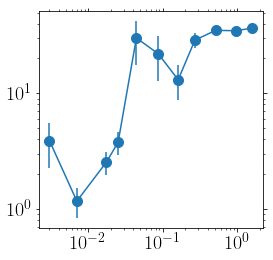

In [192]:
# #2nd: t=0.10222697257995605

# data = np.loadtxt('msd/msd.txt')
# # data2 = np.loadtxt('msd/msd2.txt')
# ax=utl.PltErr(data[:,0],data[:,1],yerr=data[:,2],
#           xscale='log',yscale='log',Plot=False
#           )

# # utl.PltErr(data2[:,0],data2[:,1],yerr=data2[:,2],
# #           xscale='log',yscale='log',ax=ax
# #           )

## Energy barriers

In [14]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,events_directory,evlist_directory,lmpData):
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData = lmpData.coord_atoms_broken[0]
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
        self.catalog = self.ParseEvList_dir()
        
        
    def ParseEvents_dir(self):
        files = os.listdir(self.events_dir)
        d=[]
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    #print(atom_id)
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
#                    d.setdefault(event_id,[]).append(barrier) #--- store
                except:
        #            traceback.print_exc()
                    continue
            
        #--- extract types
        df=self.lmpData
        atom_ids = d[:,1]
        types = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                   '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                   lmpData
                  
                  )
eb.Parse()
eb.SplitByType()

#eb.events_id_energy extract from Events_dir
#self.energyByType extract from catalogs

#--- write to file
with open('msd/eventID_barrier.txt','w') as fp:
    np.savetxt(fp,
               np.c_[eb.events_id_energy],
               header='atom_type event_id atom_id barrier')

#--- write to file: energy from catalogs
for itype in eb.energyByType.keys():
    with open('msd/eventID_barrier_catalog_type%s.txt'%itype,'w') as fp:
    #--- concat different types
        sarr = np.c_[eb.energyByType[itype][['AtomId','eventId','barrier']]].astype(float)
        np.savetxt(fp,
                   sarr,
                   header='AtomId eventId barrier'
                  )


FileNotFoundError: [Errno 2] No such file or directory: '../simulations/test/Run0//EVENTS_DIR'

In [ ]:
# sarr = np.concatenate(list(d.values()))
# hist,edges,err=utl.GetPDF(sarr,n_per_decade=8)
# utl.PltErr(edges,hist,yerr=err,xscale='log',yscale='log')

In [ ]:
#--- assert events in catalogs are included in event dir


    #    Energy_type[int(keys)] = np.c_[df.loc[indices]]
    #    Energy_type[int(keys)].setdefault()
    # for kmc_step in kmc_steps:
    #     print(kmc_step)
    #     trueFalse = list(map(lambda x: int(x) in eb.events_id_energy.keys() ,eb.catalog[kmc_step]['eventId']))
    #     assert np.all(trueFalse),'modes %s are missing!'%(list(eb.catalog[kmc_step]['eventId'][~np.array(trueFalse)]))


In [ ]:
#--- plot energy per atom
# d={}
# for kmc_step in kmc_steps:
#     for items in np.c_[eb.catalog[kmc_step][['AtomId','barrier']]]:
#         d.setdefault(int(items[0]),[]).append(float(items[1]))

In [ ]:
# itime=90
# #filtr = msd.cna[itime].StructureType==0.0
# filtr=msd.veloc[itime].DisplacementX.abs() > 0.1
# assert np.any(filtr)
# idd = msd.veloc[itime][filtr].id.iloc[0]
# #msd.veloc[itime][filtr]

# times=list(msd.disp.keys())
# times.sort()
# #idd=10
# dispx={}
# itimec=itime
# for itime in times:
#     filtr= msd.disp[itime].id==idd
#     dispx[itime]=msd.disp[itime].DisplacementX[filtr]
# tt=lmpData.headers.Time.iloc[0::2]
# utl.PltErr(tt,
#            list(map(lambda x:dispx[x],times[0::2])),
# #           attrs={'fmt':'.'},
#            xlim=(tt[itimec-2],tt[itimec+2]),
#            attrs={'marker':'o',
#                   'markersize':6,
#                   'drawstyle':'steps-post'}
           
#           )

In [ ]:
# tt=lmpData.headers.Time.iloc[0::2]
# utl.PltErr(tt,msd.xv[:,0][0::2],
#             xlim=(tt[100],tt[130]),
#             ylim=(5,22),
#            attrs={'marker':'o',
#                   'markersize':8,
#                   'drawstyle':'steps-post'}
#           )

# # utl.PltErr(tt,msd.xv[:,1][0::2],
# # #            xlim=(tt[100],tt[130]),
# # #            ylim=(5,25),
# #            attrs={'marker':'o',
# #                   'markersize':8,
# #                   'drawstyle':'steps-post'}
# #           )

# # utl.PltErr(tt,msd.xv[:,2][0::2],
# # #            xlim=(tt[100],tt[130]),
# # #            ylim=(5,25),
# #            attrs={'marker':'o',
# #                   'markersize':8,
# #                   'drawstyle':'steps-post'}
# #           )

In [ ]:
# tt=lmpData.headers.Time.iloc[0::2]
# utl.PltErr(tt,msd.xv[:,0][0::2],
#             xlim=(tt[0],tt[50]),
#             ylim=(0,10),
#            attrs={'marker':'s',
#                   'markersize':8,
#                   'drawstyle':'steps-post'}
#           )

In [ ]:
# data = np.loadtxt('xxbarriers.txt')[:,1]

# hist, bin_edges, err = utl.GetPDF(data,n_per_decade=16)
# symbols=utl.Symbols()
# #--- plot
# utl.PltErr(bin_edges,hist,
#               yerr=err,
#        attrs=symbols.GetAttrs(),
#            xscale='log',
#            yscale='log'
#               )
            
            

In [ ]:
# lmpData.headers #.Time.iloc[0::2]

In [ ]:
# lmpData.coord_atoms_broken.keys()

In [ ]:
# !mkdir png
# symbols=utl.Symbols()

# # ans=ans_tot
# ax=utl.PltErr(ans_logAveraged[:,0],ans_logAveraged[:,1],
#            yerr=ans_logAveraged[:,2],
#            attrs=symbols.GetAttrs(count=0),
#            Plot=False,
#           )

# ax=utl.PltErr(ans[:,0],ans[:,1],
#            yerr=ans[:,2],
#            ax = ax,
#            attrs=symbols.GetAttrs(count=1),
#            Plot=False,
#           )
# utl.PltErr(None,#lmpData.times[1:],
#            None, #msd.Get()[1:],
#           xscale='log',
#           yscale='log',
#            attrs={'fmt':'-'},
#            ax=ax,
# #           ylim=(1e-4,1e-1),
#            xstr=r'$t\mathrm{(s)}$',
#            ystr=r'msd(A$^2$)',
#            title='png/msd.png'
#           )

## arrhenius law

In [14]:
class Temperature:
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
#         pdb.set_trace()
#        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
#            zip(self.temps,self.nrun))))

        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def ModifyNrun(self,dirs):
        #--- modify dirs
        count = -1
        dirs_copy = dirs[:]
        for _, indx in zip(self.temps,range(len(self.temps))):
            nrun_mod = self.nrun[indx][:]
            for y in self.nrun[indx]:
                count += 1
                x = dirs[count]
                if not os.path.isfile(x): #--- if false: remove file from "dirs"
                    dirs_copy.remove(x)
                    nrun_mod.remove(y)
            self.nrun[indx] = nrun_mod[:]

            assert len(self.nrun[indx]) > 0, 'temp = %s has no data!'%(self.temps[indx])
                
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        return dirs_copy
        
    def Parse(self,dirs):
            
        dirs = self.ModifyNrun(dirs)
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],x[0].shape)),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        
    def Plot(self,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,0],data[:,1],
                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
#                 legend=legends.Get(),
                   **kwargs
                  )
        
    def EnsAverage(self,log_scale=False,n_bins_per_decade=6):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#            pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = self.hist(data,log_scale,n_bins_per_decade=n_bins_per_decade)
            kount += nruns #self.nrun

    def hist(self,data,log_scale,n_bins_per_decade=6):
        n_thresh = 1#2 #1 #2
            #--- average
        xdata = data[:,0]
        ydata = data[:,1]
        xmin = np.floor(np.log10(xdata).min())
        xmax = np.ceil(np.log10(xdata).max())
        n_decades = int((xmax - xmin))
        bins = np.logspace(xmin,xmax,n_decades*n_bins_per_decade)
        #
        count, _ = np.histogram(xdata,bins=bins)
        xsum, _  = np.histogram(xdata,bins=bins,weights=xdata)
        weights = ydata if not log_scale else np.log10(ydata)
        ysum, _  = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,rescale=False,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            xdata = data[:,0]
            ydata = data[:,1]
            yerr = data[:,2]
            if rescale:
                ydata /= xdata
                yerr /= xdata
            utl.PltErr(xdata,ydata,
                   yerr=yerr,
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,y0,c0,alpha):
#        return y0+c0*(x/x0)**alpha
        return y0*y0+c0*x**alpha

    def func3rd(self,x,c0,alpha):
         return c0*x**alpha

    def Fit(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5),
                   fontsize=18,
                   )

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])

            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
                print('alpha=%s'%popt[2])
            y0=popt[0]
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
            if self.verbose:
                print('Temp=%s,tau=%s'%(temp,self.time_scale))
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                (self.func2nd(xdata,*popt)-y0),#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7],'label':r'$\alpha=%3.2f$'%popt[2]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           (ydata-y0),#-y0)/xdata_shift,
                           yerr=(yerr),#-y0),#/xdata_shift,
#                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           attrs=symbols.GetAttrs(count=count%7,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

    def FitLinear(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            y0=0.0,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])
            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1] - y0*y0
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func3rd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
#            y0=popt[0]
            alpha=popt[1]
            err_alpha = pcov[1,1]**0.5
            c0=popt[0]
            dc = pcov[0,0]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
#            self.time_scale = tau * (y0/c0)**(1/alpha)
#            if self.verbose:
#                print('Temp=%s,tau=%s'%(temp,self.time_scale))
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
#                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                self.func3rd(xdata,*popt),
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           ydata,
                           yerr=yerr,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )
            
    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )


    


### main()

mkdir: png: File exists
single realizations
ensemble average


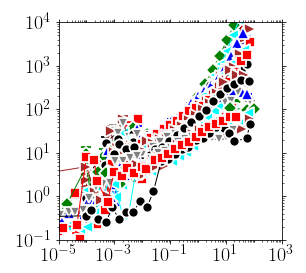

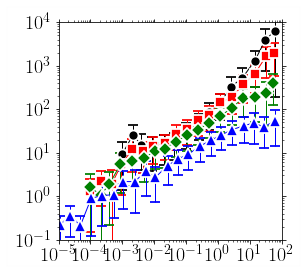

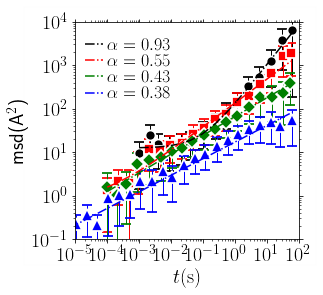

In [30]:
def main():
    if not eval(confParser['flags']['RemoteMachine']):
        !mkdir png
        #--- temp object
        temp = Temperature(
    #        [1000,1200],8,
#            [0],[[0,1,2,3,4]],#
            [0,1,2,3],[list(range(8))]*10,
#             verbose = True,
                         )
        #
        #--- parse data
    #    temp.Parse(['./msd/msd.txt'])
        temp.Parse( list(map(lambda x:'multiHydrogenDiffusionLong/rho/rho%s/Run%s/msd/msd.txt'%(x[0],x[1]),
                            temp.temps_runs ))
                 )
        #
        #--- plot
#         xlim=(1e-8,1e2)
#         ylim=(1e-2,1e2)
        xlim=(1e-5,1e2)
        ylim=(1e-1,1e4)
        print('single realizations')
        temp.Plot(**{
                      'xscale':'log',
                      'yscale':'log',
                       'attrs':{'fmt':'-'},
                        'xlim':xlim,
                         'ylim':ylim,
                             'ndecade_x':2,
    #                   'xstr':r'$t\mathrm{(s)}$',
    #                   'ystr':r'msd(A$^2$)',
    #                   'title':'png/msd_temp_ni.png',
            'bbox_to_anchor':(0.01,0.3,0.5,0.5)
        })
        #
        #--- plot average
        #
#        print(temp.nrun)
        if len(temp.nrun[0]) > 1:
            print('ensemble average')
            temp.EnsAverage(log_scale=True,n_bins_per_decade=3)
            temp.PlotAverage(**{
                      'yscale':'log',
                      'xscale':'log',
                        'xlim':xlim,
                         'ylim':ylim,
    #                     'xstr':r'$t\mathrm{(s)}$',
    #                   'ystr':r'msd(A$^2$)',
#                             'ndecade_x':2,
#                       'title':'png/msd_temp_cantor.png',
            })

        #
        #--- fit
        #
        temp.Fit(Plot=True,
                 shift=False,
    #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
    #            p0=[[1e-4, 1e6, 1.0]],
    #            p0=[[1e-2, 1e6, 1.0]],
                 sigma=True, #--- comment for ni
                 xlo=xlim[0],
                 plotAttrs={'yscale':'log',
                      'xscale':'log',
                        'xlim':xlim,
                         'ylim':ylim,
                         'xstr':r'$t\mathrm{(s)}$',
                       'ystr':r'msd(A$^2$)',
#                            'ndecade_x':2,
                        'bbox_to_anchor':(0,0.5,0.5,0.5),
                       'title':'png/multipleH.png'},
                )

    #     temp.FitLinear(Plot=True,
    #              shift=True,
    # #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
    #             p0=[[1e6, 1.0]],
    #              sigma=True, #--- comment for ni
    # #             xlo=1e-12,
    #              y0 = 0.0133,
    #              plotAttrs={'yscale':'log',
    #                   'xscale':'log',
    # #                   'xlim':(4e-13,8e-4),
    #                    'ylim':(1e-6,1e-2),
    # #                     'xstr':r'$t\mathrm{(s)}$',
    # #                   'ystr':r'msd(A$^2$)',
    #                         'ndecade_x':2,
    #                     'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
    #                    'title':'png/msd_temp_cantor_fit.png'},
    #             )
    #


    #    temp.PlotDiff(**{
    #                  'yscale':'log',
    #                   'xlim':(1e-12,1e-3),
    #                   'ylim':(1e-4,1e-1),
    #                   xstr=r'$1/T(K^{-1})$',
    #                   ystr=r'$D(m^2/s)$',
    #                    'title':'png/D_temp_cantor.png',
    #                    }
    #                )

    #     temp.PlotExponent(**{
    # #                  'yscale':'log',
    # #                   'xlim':(1e-10,1e-3),
    # #                   'ylim':(.5,1.1),
    # #                   xstr=r'$1/T(K^{-1})$',
    # #                   ystr=r'$D(m^2/s)$',
    # #                    'title':'png/alpha_temp_ni.png',
    #                     }
    #                 )

main()

mkdir: png: File exists
Parsing: 0 data.shape is: (23, 3)
Parsing: 1 data.shape is: (23, 3)
Parsing: 2 data.shape is: (23, 3)
Parsing: 3 data.shape is: (19, 3)
Parsing: 4 data.shape is: (23, 3)
Parsing: 5 data.shape is: (22, 3)
Parsing: 7 data.shape is: (19, 3)
single realizations
[[0, 1, 2, 3, 4, 5, 7]]
ensemble average
data.shape: (7,)
limits: -inf inf
filtr= [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Temp=0,y0,c0,alpha [3.424747342403092, 151.90717065531612, 0.997292208837036] [[ 2.25181153e-02 -6.79240671e-01  2.29228116e-03]
 [-6.79240671e-01  1.17600920e+02 -1.96062970e-01]
 [ 2.29228116e-03 -1.96062970e-01  1.19849791e-03]]
alpha=0.997292208837036
Temp=0,tau=0.022314058025251802


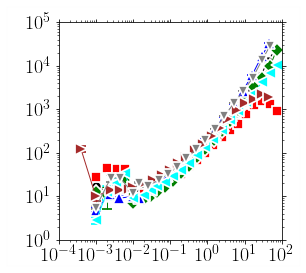

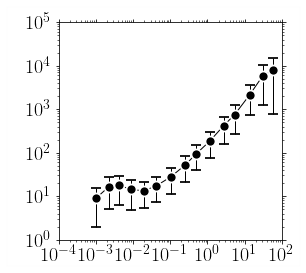

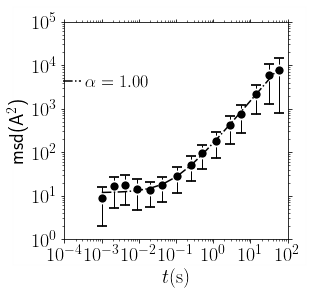

In [19]:
def main():
    if not eval(confParser['flags']['RemoteMachine']):
        !mkdir png
        #--- temp object
        temp = Temperature(
    #        [1000,1200],8,
            [0],[[0,1,2,3,4,5,7]],#
#            [0],[list(range(8))],
             verbose = True,
                         )
        #
        #--- parse data
    #    temp.Parse(['./msd/msd.txt'])
        temp.Parse( list(map(lambda x:'singleHydrogenDiffusionLong/Run%s/msd/msd.txt'%(x[1]),
                            temp.temps_runs ))
                 )
        #
        #--- plot
        xlim=(1e-4,1e2)
        ylim=(1e0,1e5)
        print('single realizations')
        temp.Plot(**{
                      'xscale':'log',
                      'yscale':'log',
                       'attrs':{'fmt':'-'},
                         'xlim':xlim,
                          'ylim':ylim,
#                              'ndecade_x':2,
    #                   'xstr':r'$t\mathrm{(s)}$',
    #                   'ystr':r'msd(A$^2$)',
    #                   'title':'png/msd_temp_ni.png',
            'bbox_to_anchor':(0.01,0.3,0.5,0.5)
        })
        #
        #--- plot average
        #
        print(temp.nrun)
        if len(temp.nrun[0]) > 1:
            print('ensemble average')
            temp.EnsAverage(log_scale=True,n_bins_per_decade=3)
            temp.PlotAverage(**{
                      'yscale':'log',
                      'xscale':'log',
                         'xlim':xlim,
                          'ylim':ylim,
    #                     'xstr':r'$t\mathrm{(s)}$',
    #                   'ystr':r'msd(A$^2$)',
#                             'ndecade_x':2,
#                       'title':'png/msd_temp_cantor.png',
            })

        #
        #--- fit
        #
        temp.Fit(Plot=True,
                 shift=False,
    #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
    #            p0=[[1e-4, 1e6, 1.0]],
    #            p0=[[1e-2, 1e6, 1.0]],
                 sigma=True, #--- comment for ni
#                 xlo=xlim[0],
                 plotAttrs={'yscale':'log',
                      'xscale':'log',
                         'xlim':xlim,
                          'ylim':ylim,
                         'xstr':r'$t\mathrm{(s)}$',
                       'ystr':r'msd(A$^2$)',
#                            'ndecade_x':2,
                        'bbox_to_anchor':(-0.05,0.33,0.5,0.5),
                       'title':'png/singleH.png'},
                )

    #     temp.FitLinear(Plot=True,
    #              shift=True,
    # #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
    #             p0=[[1e6, 1.0]],
    #              sigma=True, #--- comment for ni
    # #             xlo=1e-12,
    #              y0 = 0.0133,
    #              plotAttrs={'yscale':'log',
    #                   'xscale':'log',
    # #                   'xlim':(4e-13,8e-4),
    #                    'ylim':(1e-6,1e-2),
    # #                     'xstr':r'$t\mathrm{(s)}$',
    # #                   'ystr':r'msd(A$^2$)',
    #                         'ndecade_x':2,
    #                     'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
    #                    'title':'png/msd_temp_cantor_fit.png'},
    #             )
    #


    #    temp.PlotDiff(**{
    #                  'yscale':'log',
    #                   'xlim':(1e-12,1e-3),
    #                   'ylim':(1e-4,1e-1),
    #                   xstr=r'$1/T(K^{-1})$',
    #                   ystr=r'$D(m^2/s)$',
    #                    'title':'png/D_temp_cantor.png',
    #                    }
    #                )

    #     temp.PlotExponent(**{
    # #                  'yscale':'log',
    # #                   'xlim':(1e-10,1e-3),
    # #                   'ylim':(.5,1.1),
    # #                   xstr=r'$1/T(K^{-1})$',
    # #                   ystr=r'$D(m^2/s)$',
    # #                    'title':'png/alpha_temp_ni.png',
    #                     }
    #                 )

main()

mkdir: png: File exists
Parsing: 0 data.shape is: (19, 3)
Parsing: 1 data.shape is: (19, 3)
Parsing: 2 data.shape is: (19, 3)
Parsing: 3 data.shape is: (19, 3)
Parsing: 4 data.shape is: (19, 3)
Parsing: 5 data.shape is: (19, 3)
Parsing: 6 data.shape is: (19, 3)
Parsing: 7 data.shape is: (15, 3)
single realizations
[[0, 1, 2, 3, 4, 5, 6, 7]]
ensemble average
data.shape: (8,)
limits: 0.0001 inf
filtr= [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Temp=0,y0,c0,alpha [3.939087254849765, 67.80887601767867, 0.7653653675207585] [[ 7.00618577e-02 -1.65941622e+00  2.08128016e-02]
 [-1.65941622e+00  1.33108391e+02 -6.28262159e-01]
 [ 2.08128016e-02 -6.28262159e-01  1.36525826e-02]]
alpha=0.7653653675207585
Temp=0,tau=0.024278816024975065


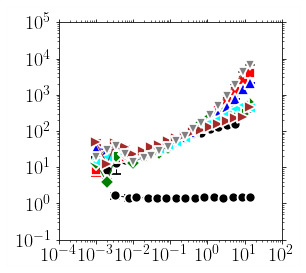

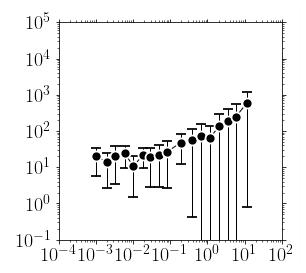

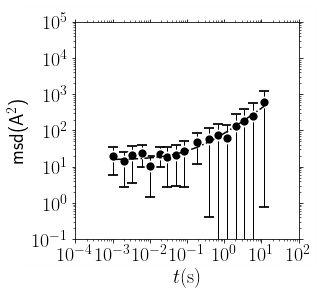

In [203]:
def main():
    if not eval(confParser['flags']['RemoteMachine']):
        !mkdir png
        #--- temp object
        temp = Temperature(
    #        [1000,1200],8,
            [0],[list(range(8))],
             verbose = True,
                         )
        #
        #--- parse data
    #    temp.Parse(['./msd/msd.txt'])
        temp.Parse( list(map(lambda x:'singleHydrogenDiffusion/Run%s/msd/msd.txt'%(x[1]),
                            temp.temps_runs ))
                 )
        #
        #--- plot
        xlim=(1e-4,1e2)
        ylim=(1e-1,1e5)
        print('single realizations')
        temp.Plot(**{
                      'xscale':'log',
                      'yscale':'log',
                       'attrs':{'fmt':'-'},
                       'xlim':xlim,
                        'ylim':ylim,
    #                   'xstr':r'$t\mathrm{(s)}$',
    #                   'ystr':r'msd(A$^2$)',
    #                   'title':'png/msd_temp_ni.png',
            'bbox_to_anchor':(0.01,0.3,0.5,0.5)
        })
        #
        #--- plot average
        #
        print(temp.nrun)
        if len(temp.nrun[0]) > 1:
            print('ensemble average')
            temp.EnsAverage(log_scale=True,n_bins_per_decade=4)
            temp.PlotAverage(**{
                      'yscale':'log',
                      'xscale':'log',
                       'xlim':xlim,
                        'ylim':ylim,
    #                     'xstr':r'$t\mathrm{(s)}$',
    #                   'ystr':r'msd(A$^2$)',
                       'title':'png/msd_temp_cantor.png',
            })

        #
        #--- fit
        #
        temp.Fit(Plot=True,
                 shift=False,
    #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
    #            p0=[[1e-4, 1e6, 1.0]],
    #            p0=[[1e-2, 1e6, 1.0]],
                 sigma=True, #--- comment for ni
                xlo=xlim[0],
                 plotAttrs={'yscale':'log',
                      'xscale':'log',
                       'xlim':xlim,
                        'ylim':ylim,
                         'xstr':r'$t\mathrm{(s)}$',
                       'ystr':r'msd(A$^2$)',
    #                        'ndecade_x':2,
                        'bbox_to_anchor':(-0.05,0.33,0.5,0.5),
                       'title':'png/pureH.png'},
                )

    #     temp.FitLinear(Plot=True,
    #              shift=True,
    # #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
    #             p0=[[1e6, 1.0]],
    #              sigma=True, #--- comment for ni
    # #             xlo=1e-12,
    #              y0 = 0.0133,
    #              plotAttrs={'yscale':'log',
    #                   'xscale':'log',
    # #                   'xlim':(4e-13,8e-4),
    #                    'ylim':(1e-6,1e-2),
    # #                     'xstr':r'$t\mathrm{(s)}$',
    # #                   'ystr':r'msd(A$^2$)',
    #                         'ndecade_x':2,
    #                     'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
    #                    'title':'png/msd_temp_cantor_fit.png'},
    #             )
    #


    #    temp.PlotDiff(**{
    #                  'yscale':'log',
    #                   'xlim':(1e-12,1e-3),
    #                   'ylim':(1e-4,1e-1),
    #                   xstr=r'$1/T(K^{-1})$',
    #                   ystr=r'$D(m^2/s)$',
    #                    'title':'png/D_temp_cantor.png',
    #                    }
    #                )

    #     temp.PlotExponent(**{
    # #                  'yscale':'log',
    # #                   'xlim':(1e-10,1e-3),
    # #                   'ylim':(.5,1.1),
    # #                   xstr=r'$1/T(K^{-1})$',
    # #                   ystr=r'$D(m^2/s)$',
    # #                    'title':'png/alpha_temp_ni.png',
    #                     }
    #                 )

main()

In [ ]:
# data = np.loadtxt('Diffusion.dat')
# nrow_skip = 0
# nh=10 #--- hidrogen
# utl.PltErr(data[:,0][nrow_skip:],data[:,3][nrow_skip:]/nh,
# #          xscale='log',yscale='log',
#           )

### vacancy dynamics

mkdir: png: File exists
ensemble average


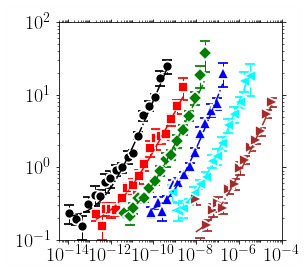

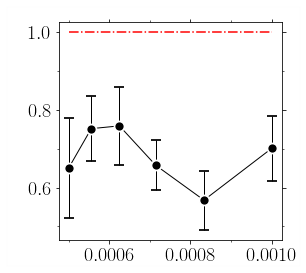

In [40]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    temp_vac = Temperature(
        [1000,1200,1400,1600,1800,2000],8,
#        [1400],8,
#        [1000,1200,1400,1600,1800,2000],1,
#       [1000,1200,1400,1600,1800,2000],1,
#        np.arange(1000,1440,80),1,
#         verbose = True,
                     )
    #
    #--- parse data
#    temp_vac.Parse(['./msd/msd_vac.txt'])
    temp_vac.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
                        temp_vac.temps_runs ))
             )
    #
    #--- plot
#     print('single realizations')
#     temp_vac.Plot(**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    #
    #--- plot average
    #
    if temp_vac.nrun > 1:
        print('ensemble average')
        temp_vac.EnsAverage(log_scale=False,n_bins_per_decade=4)
#         temp_vac.PlotAverage(**{
#                   'yscale':'log',
#                   'xscale':'log',
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-4,1e-1),
# #                     'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
#                    'title':'png/msd_temp_cantor.png',
#         })

    #
    #--- fit
    #
    temp_vac.Fit(Plot=True,
             shift=True,
#             bounds=(np.array([-np.inf, -np.inf,0]), np.array([np.inf, np.inf,np.inf])),
            p0=[[1e-1, 1e6, 1.0]],
#            p0=[[0.4058429798422189, 87091.79927150169, 0.9788537305407521]],
#             p0=[[-1, 1e6, 1.0]],
             sigma=True, #--- comment for ni
#              xlo=8e-11,
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                   'xlim':(4e-13,8e-4),
                   'ylim':(1e-1,1e2),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                        'ndecade_x':2,
                    'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
                   'title':'png/msd_temp_cantor_fit_vac.png'},
            )
    
#     temp_vac.FitLinear(Plot=True,
#              shift=True,
# #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
#             p0=[[1e6, 1.0]],
# #             sigma=True, #--- comment for ni
# #             xlo=1e-12,
#              y0 = 0.7,
#              plotAttrs={'yscale':'log',
#                   'xscale':'log',
# #                   'xlim':(4e-13,8e-4),
# #                   'ylim':(1e-6,1e-2),
# #                     'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
#                         'ndecade_x':2,
#                     'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
#                    'title':'png/msd_temp_cantor_fit.png'},
#             )


#     temp.PlotDiff(**{
#                   'yscale':'log',
# #                   'xlim':(1e-12,1e-3),
# #                   'ylim':(1e-4,1e-1),
# #                   xstr=r'$1/T(K^{-1})$',
# #                   ystr=r'$D(m^2/s)$',
#                     'title':'png/D_temp_cantor.png',
#                     }
#                 )

    temp_vac.PlotExponent(**{
#                  'yscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(.5,1.1),
#                   xstr=r'$1/T(K^{-1})$',
#                   ystr=r'$D(m^2/s)$',
#                    'title':'png/alpha_temp_nicocr_vac.png',
                    }
                )
    


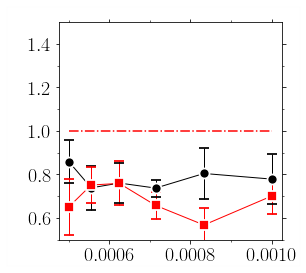

In [34]:
if not eval(confParser['flags']['RemoteMachine']):
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(0.1,0.5,0.5,0.5))
    #
    ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
    utl.PltErr(1.0/np.array(temp.temps),
               list(map(lambda x:temp.exponent[x][0],temp.temps)),
               yerr=list(map(lambda x:1.0*(temp.exponent[x][1]-temp.exponent[x][2]),temp.temps)),
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Total}$'),
               ax=ax,
               Plot=False,
    #           **kwargs
              )

    utl.PltErr(1.0/np.array(temp_vac.temps),
               list(map(lambda x:temp_vac.exponent[x][0],temp_vac.temps)),
               yerr=list(map(lambda x:1.0*(temp_vac.exponent[x][1]-temp_vac.exponent[x][2]),temp_vac.temps)),
               attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Vacancy}$'),
               DrawFrame=DRAW_FRAME,
               ax=ax,
                       ylim=(.5,1.5),
#               halfopen=True,
#               legend=legends.Get(),
                        title='png/alpha_temp_cantor.png',
              )


### robustness

In [ ]:
class Robustness(Temperature):
    
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun,verbose=verbose)

    def FitRange(self,decades=9):
        self.Fit(Plot=False,shift=False,
                    p0=[[1e-2, 1e6, 1.0]],
                 sigma=True, #--- comment for ni
                     plotAttrs={'bbox_to_anchor':(-0.05,0.23,0.5,0.5)}
                )

        self.xlo = np.floor(np.log2(self.smat[:,0].min()))
        xhii = np.ceil(np.log2(self.smat[:,0].max()))
        self.xrange = 2**np.arange(xhii+1,xhii-decades,-1)
        
    def Fitting(self):
        #--- bounds
        self.exponents = np.zeros(len(self.xrange))
        self.error = np.zeros(len(self.xrange))
        self.npoin = np.zeros(len(self.xrange))
        
        npoint_filtrd0 = self.smat.shape[0]
        for xhi, indx in zip(self.xrange,range(len(self.xrange))):
            self.Fit(Plot=True,
                     shift=False,
        #             bounds=([0, 0, 0,0.999], [1e-2, 1e-3, 1,1.001]),
                        p0=[[1e-2, 1e6, 1.0]],
                     sigma=True, #--- comment for ni
                     xlo=2**self.xlo,xhi=xhi,
                     plotAttrs={'yscale':'log',
                          'xscale':'log',
        #                   'xlim':(4e-13,8e-4),
        #                   'ylim':(1e-4,1e-1),
        #                     'xstr':r'$t\mathrm{(s)}$',
        #                   'ystr':r'msd(A$^2$)',
                                'ndecade_x':2,
                            'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
    #                       'title':'png/msd_temp_nicocr_fit.png'
                               },
                    )
            
            #--- check if decrease in tc leads to fewere points
#             npoint_filtrd = np.sum(self.filtr)
#             if self.verbose:
#                 print('npoint_filtrd=',npoint_filtrd)
#             #if indx > 0:
#             if npoint_filtrd == npoint_filtrd0 and indx > 0:
#                 continue
# #                    , '%s >= %sdecrease ndecades!'%(npoint_filtrd,npoint_filtrd0)
#             npoint_filtrd0 = npoint_filtrd
            
            #--- assign
            self.npoin[indx] = np.sum(self.filtr)
            if self.npoin[indx] == self.npoin[indx-1] and indx > 0:
                continue
            self.exponents[indx] = self.popt[-1]
            x = self.temps[ 0 ]
            self.error[indx] = 0.5*(self.exponent[x][1]-self.exponent[x][2])
        
if not eval(confParser['flags']['RemoteMachine']):

    symbols = utl.Symbols()
    ax = utl.PltErr(None,None,Plot=False)

    temps = [1200] #[1000,1200,1400,1600,1800,2000]
    indices = [1] #range(10)
    for temperature, indx in zip(temps,indices):
        try:
            rb = Robustness([temperature],8,
#                            verbose = True

                            )

            #--- parse data
#            rb.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
            rb.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#            rb.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                                rb.temps_runs ))
                     )

            #--- plot average
            if rb.nrun > 1:
                print('ensemble average')
                rb.EnsAverage(log_scale=False,n_bins_per_decade=4)
#                 rb.PlotAverage(**{
#                           'yscale':'log',
#                           'xscale':'log',
#         #                   'xlim':(1e-10,1e-3),
#         #                   'ylim':(1e-4,1e-1),
#         #                     'xstr':r'$t\mathrm{(s)}$',
#         #                   'ystr':r'msd(A$^2$)',
# #                            'title':'png/msd_temp_cantor.png',
#                 })
            #
            #--- fit
            #
            rb.FitRange(decades=10)
            rb.Fitting()


            #--- get data
            filtr = np.all([rb.exponents>0,rb.exponents<2],axis=0)
            utl.PltErr(rb.xrange[filtr],rb.exponents[filtr],yerr=rb.error[filtr],
                       attrs=symbols.GetAttrs(count=indx%7),
                       ax=ax,
                        Plot=False,
                      )
        except:
            print('increase fit range!')
            traceback.print_exc()
            continue

    utl.PltErr(ax.axis()[:2],[1,1],Plot=False,ax=ax,
                attrs={'fmt':'-.','color':'red'},
                       ylim=(0,2),
                      xscale='log',
                       DrawFrame=DRAW_FRAME,
                       title='png/exponentH_ni_T%sK.png'%temperature,
              )

### per type

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    ax = utl.PltErr(None,None,Plot=False)
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
 
                       
    ntype = 5
    for itype in range(1,ntype+1):
        temp = Temperature(#[1000],3
                           list(map(int,np.linspace(1000,1400,11))),3
                          )
        temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sK_ensemble/Run%s/msd/msd_type%s.txt'%(x[0],x[1],itype),
                            temp.temps_runs ))
                  )
        #
  #      print('single realizations')
  #      temp.Plot()
        #
        print('ensemble average: type %s'%itype)
        temp.EnsAverage()
#         temp.PlotAverage()
#         #
        temp.Fit(#Plot=True,
        #         verbose=True
        )
#         temp.PlotDiff()
        
        #--- plot
        utl.PltErr(1/np.array(list(temp.Diffusion.keys())),
                   list(map(lambda x:temp.Diffusion[x],list(temp.Diffusion.keys()))),
                       Plot=False,
                   ax=ax,
                   attrs=symbols.GetAttrs(count=(itype-1)%7,label=r'$%s$'%temp),
                 )
    utl.PltErr(None,None,
               ax=ax,
               yscale='log',
               ylim=(1e-15,1e-11),
              xstr=r'$1/T(K^{-1})$',
              ystr=r'$D(m^2/s)$',
              )

In [ ]:
#tauu = temp.time_scale

## correlated noise

mkdir: png: File exists


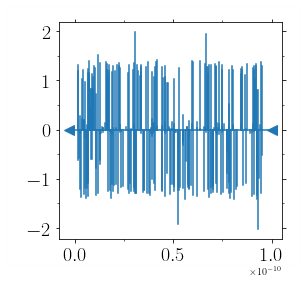

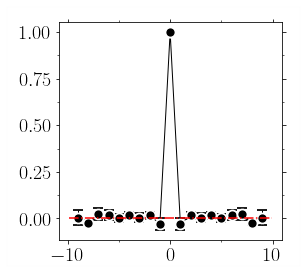

In [626]:
class Noise(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotNoise(self, col_a = 1, col_b=1,
                  **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.crltns_mean_ab = {}
        self.crltns_mean_ba = {}
        self.crltns_err_ab = {}
        self.crltns_err_ba = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
                
            #--- correlations
            crltns_ab = np.c_[list(map(lambda x: Noise.Crltns(x[:,col_a],x[:,col_b]),data))]
            crltns_ba = np.c_[list(map(lambda x: Noise.Crltns(x[:,col_b],x[:,col_a]),data))]
            self.crltns_mean_ab[temp] = np.mean(crltns_ab,axis=0)
            self.crltns_mean_ba[temp] = np.mean(crltns_ba,axis=0)
            self.crltns_err_ab[temp] = np.std(crltns_ab,axis=0)/self.nrun**0.5
            self.crltns_err_ba[temp] = np.std(crltns_ba,axis=0)/self.nrun**0.5
            kount += self.nrun
        #--- plot
        irun = 0
        smat=data[irun]
        for i,j in zip(smat[:,0],smat[:,col_a]):
            utl.PltErr([i,i],[0,j],
                       attrs={'fmt':'-','color':'C0'},
                       ax=self.ax,
                       Plot=False,
#                       **kwargs
                      )
        utl.PltErr(self.ax.axis()[:2],[0,0],
                        ax=self.ax,
                   DrawFrame=DRAW_FRAME,
                       **kwargs
                       )

            
        
    def PlotSum(self, col_a = 1, col_b=1,
                  **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
                
            #--- correlations
            #--- plot
            irun = 0
            smat=data[irun]
            utl.PltErr(smat[:,0],np.cumsum(smat[:,col_a]),
                       attrs={'drawstyle':'steps-post'},
                       ax=self.ax,
                       Plot=False,
                   DrawFrame=DRAW_FRAME,
                       **kwargs
                      )

#             utl.PltErr(lmpData.headers['Time'][1:-1:2],np.cumsum(xvv[:,2]),
#                       attrs={'drawstyle':'steps-post'},
#                       )

            
            kount += self.nrun
        
    @staticmethod        
    def Crltns(a,b,n=10):
        cr,err=Noise.CrossCr(a,b)
        return cr[:n] #np.c_[cr,err]
    
    def zscore(slist):
        slist -= np.mean(slist)
        slist /= np.std( slist )
        return slist

    def CrossCr(x,y, ZSCORE = True):
        if ZSCORE:
            x -= np.mean( x )
            y -= np.mean( y )

            x /= np.std( x )
            y /= np.std( y )
        assert len(x) == len(y), 'len(x)=%s,len(y)=%s'%(len(x),len(y))
        n = len(x)
        x=np.concatenate([x,np.zeros(n)],axis=0)
        y=np.concatenate([y,np.zeros(n)],axis=0)
        ones = np.concatenate([np.ones(n),np.zeros(n)],axis=0)

        X=np.fft.fft(x)
        Y=np.fft.fft(y)
        Z=X.conjugate()*Y

        cq = np.fft.fft( ones )
        count = np.fft.ifft( cq.conjugate()*cq ).real[:n]

        z=np.fft.ifft(Z)[:n] / count

        return z, 1.0/np.sqrt(count)




    def PlotCrltns(self,**kwargs):

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        
        ax = utl.PltErr(None,None,Plot=False)
        for temp, indx in zip(self.temps,range(len(self.temps))):
            n=noise.crltns_mean_ba[temp].shape[0]
            x=np.concatenate([-np.arange(n-1,-1,-1),np.arange(n)])
            indices=np.arange(n-1,-1,-1)
            y=np.concatenate([noise.crltns_mean_ba[temp][indices],
                              noise.crltns_mean_ab[temp]])
            yerr=np.concatenate([noise.crltns_err_ba[temp][indices],
                              noise.crltns_err_ab[temp]])


            utl.PltErr(x,
                       y,
                       yerr=2*yerr,
                       attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp),
                       Plot=False,
                       ax=ax,
                      )
            
        utl.PltErr(ax.axis()[:2],[0,0],
                   attrs={'fmt':'-.r'},
                   Plot=False,
            DrawFrame=DRAW_FRAME,
                   ax=ax,
                       **kwargs
                  )
    

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    noise = Noise(
#        [1000,1200,1400,1600,1800,2000],8,
        [2000],8,
#         verbose = True,
                     )
    #
    #--- parse data
#    noise.Parse(['./msd/noise.txt'])
#    temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
    noise.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/noise.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                        noise.temps_runs ))
             )
    #
    #--- plot
    noise.PlotNoise(col_a=1,col_b=1,**{
#                   'attrs':{'fmt':'-','color':'C0'},
#                   'xlim':(0,0.5e-09),
#                    'ylim':(-2,2),
#                     'xticks':([r'$0$',r'$2$',r'$4$'],[0,2e-10,4e-10]),
#                   'title':'png/noise_z_nicocr.png',
#                   'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    #
    #--- plot sum
#     noise.PlotSum(col_a=1,col_b=1,**{
# #                  'xscale':'log',
# #                  'yscale':'log',
#                    'xlim':(0,1e-09),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })

    
    #
    noise.PlotCrltns(
        **{
#                   'yscale':'log',
#                   'xscale':'log',
#                   'xlim':(1e-10,1e-3),
#                    'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                   'title':'png/noiseCrltn_yz_nicocr.png',
        })



## wait times

mkdir: png: File exists


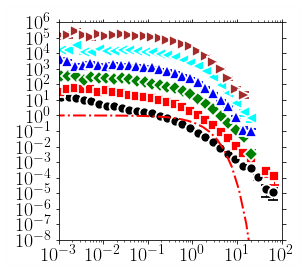

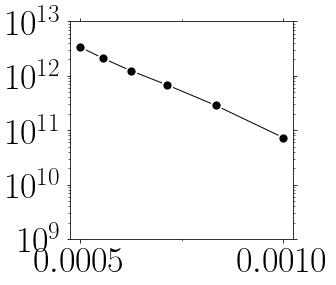

In [72]:
class Stats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotWaitTimes(self,scale=False,
                      scalePowerLaw=False,
                      shift=False,
                      n_per_decade=6,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            data = list(map(lambda x:self.GetWaitTimes(x),data))
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            data = np.concatenate(data) #,axis=0)
            rate = 1.0 / data.mean()
            self.mean_rate[temp] = [ rate, rate*(1/len(data)**0.5)]
            if scale:
                data /= data.mean() 
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
            if scalePowerLaw:
                alpha = 2 #1.5
                hist *= bin_edges ** alpha 
                err *= bin_edges ** alpha 
            #--- plot
            if shift:
                hist *= 10 ** indx 
                err *= 10 ** indx 
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount += self.nrun
        self.data_regr = np.c_[bin_edges,hist,err]
        #
        xhi=self.ax.axis()[1]
        xarr = np.logspace(np.log10(xhi)-5.0,np.log10(xhi),32)
        utl.PltErr( xarr if scale else None,
                   np.exp(-xarr) if scale else None,
                   attrs={'fmt':'-.r','lw':2},
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def PlotAverageRate(self,**kwargs):
#        print(list(self.temps_runs))
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        data = list(map(lambda x:self.mean_rate[ x ][0], self.temps))
        err = list(map(lambda x:self.mean_rate[ x ][1], self.temps))
#             utl.PltErr(data[:,0],data[:,1],
#                    yerr=data[:,2],
#                    ax = self.ax,
#                    attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
#                    Plot=False,
#                   )

        utl.PltErr(1.0/np.array(self.temps),
                   data,
                   yerr=err,
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    
    def GetWaitTimes(self,times):
#         times = np.array(np.c_[self.lmpData.headers['Time'].iloc[0::2]].flatten())
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
        filtr = dtt > 0.0
        return dtt[filtr]

    #
    def Barries(self):
        Barrier = self.lmpData.headers['Barrier'].iloc[1::2]        
        hist, bin_edges, err = utl.GetPDF(Barrier,linscale=True,n_per_decade=16)
        utl.PltErr(bin_edges,hist,
                  yerr=err,
                   attrs=symbols.GetAttrs(),
                   #yscale='log',
                   #xscale='log',
                   xstr=r'$\Delta E$',
                   ystr=r'$P(\Delta E)$'
                  )

    def func(self,x,k,alpha,beta,t0):
        return k*(x/t0)**(-alpha)/(1+(x/t0)**(beta-alpha))
    
    
    def fit(self,edge,hist,err):
        xdata=edge
        ydata=hist
        yerr=err
        popt, pcov = curve_fit(self.func,xdata,ydata,
                              p0=(1.0,0.4,2,1.0),
                               sigma=yerr,
                              )

        ax=utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,self.func(edge,*popt),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax,
                   ylim=(1e-5,1000),
                  )
#        assert popt[-1]>0
        print('k,alpha,beta,t0',popt)
        return popt[0]

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = Stats(
         [1000,1200,1400,1600,1800,2000],8,
#        [1000,1200,1400,1600,1800,2000],1,
#        [2000],8,
#        np.arange(1000,1440,80),1,
#        verbose=True
                     )
#    stats.Parse(['msd/event_times.txt'])
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
                        stats.temps_runs ))
              )
    stats.PlotWaitTimes(scale=True,shift=True,scalePowerLaw=False,
                        n_per_decade=6,
                        **{'xscale':'log',
                  'yscale':'log',
                    'xlim':(1e-3,100),
                    'ylim':(1e-8,1e6), #(1e-5,1e2),
#                    'ndecade_y':2,
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                   'title':'png/waitTimes_unscaled_ni.png'},

                       )
#     stats.PlotWaitTimes(scale=True,scalePowerLaw=True,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-9,1e-3),
#                    'ylim':(1e-5,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                    'title':'png/waitTimes_rescaled_ni.png'},
#                       )
    stats.PlotAverageRate(
                **{
                    'fontsize':36,
#                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-9,1e-3),
                   'ylim':(1e9,1e13), #(1e-5,1e2),
#                           'xstr':r'$1/T$',
#                           'ystr':r'$\lambda$',
                   'title':'png/eventRate_nicocr.png'},
    
    )
    #
#    stats.fit(stats.data_regr[:,0],stats.data_regr[:,1],stats.data_regr[:,2])
    #stats.Barries()

### effective E

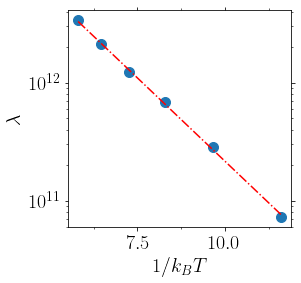

energy=0.6495992792586722 eV
scaled energy= 4.568661260693625


In [75]:
def func(x,a,b):
    return a*np.exp(-b*x)

if not eval(confParser['flags']['RemoteMachine']):
    kb=8.61732814974056e-05
    xdata = 1/(kb*np.array(stats.temps))
    ydata = list(map(lambda x:stats.mean_rate[x][0],stats.temps))
    yerr = list(map(lambda x:stats.mean_rate[x][1],stats.temps))
    popt,pcov=curve_fit(func,xdata,ydata,
             p0=[1e12,1],
             sigma=yerr
             )
    #
    ax=utl.PltErr(xdata,ydata,yerr=yerr,
               fmt='.',
               Plot=False

              )
    utl.PltErr(xdata,func(xdata,*popt),
               yscale='log',
               attrs={'fmt':'-.r'},
               ax=ax,
               xstr=r'$1/k_BT$',ystr=r'$\lambda$'

              )
    Tm=[1650,2100][0]
    print('energy=%s eV'%popt[1])
    print('scaled energy=',popt[1]/kb/Tm)

### reduced temperature scale

In [94]:
if not eval(confParser['flags']['RemoteMachine']):
    #Tm = 1650
    xdata = np.array(stats.temps)
    ydata = list(map(lambda x:stats.mean_rate[x][0],stats.temps))
    yerr = list(map(lambda x:stats.mean_rate[x][1],stats.temps))
    np.savetxt('ni2nd.txt',np.c_[xdata,ydata,yerr],header='T lambda err')


<AxesSubplot:xlabel='$T_m/T$', ylabel='$\\lambda$'>

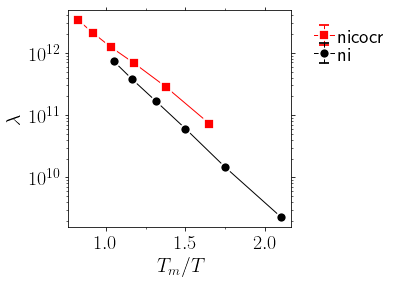

In [39]:
if not eval(confParser['flags']['RemoteMachine']):
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))



    Tm = 1650
    data_nicocr = np.loadtxt('nicocr.txt')
    xdata = Tm/data_nicocr[:,0]
    ydata = data_nicocr[:,1]
    yerr = data_nicocr[:,2]

    ax=utl.PltErr(xdata,ydata,yerr=yerr,
                    attrs=symbols.GetAttrs(count=1,label=r'nicocr'),
              Plot=False,
             yscale='log'
             )

    Tm = 2100
    data_ni = np.loadtxt('ni.txt')
    xdata = Tm/data_ni[:,0]
    ydata = data_ni[:,1]
    yerr = data_ni[:,2]

    utl.PltErr(xdata,ydata,yerr=yerr,
                    attrs=symbols.GetAttrs(count=0,label=r'ni'),
            ax=ax,
              Plot=False,
             yscale='log',
                     legend=legends.Get(),
               xstr=r'$T_m/T$',ystr=r'$\lambda$'
             )

    # Tm = 1607
    # data_ni = np.loadtxt('cantor.txt')
    # xdata = Tm/data_ni[:,0]
    # ydata = data_ni[:,1]
    # yerr = data_ni[:,2]

    # utl.PltErr(xdata,ydata,yerr=yerr,
    # #          fmt='.',
    #         ax=ax,
    #           Plot=False,
    #          yscale='log'
    #          )

    # Tm = 2100
    # data_ni = np.loadtxt('ni2nd.txt')
    # xdata = Tm/data_ni[:,0]
    # ydata = data_ni[:,1]
    # yerr = data_ni[:,2]

    # utl.PltErr(xdata,ydata,yerr=yerr,
    # #          fmt='.',
    #         ax=ax,
    #           Plot=False,
    #          yscale='log',
    #                  legend=legends.Get(),

    #          )


### Tm

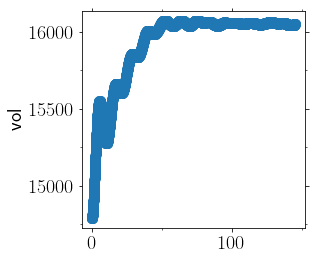

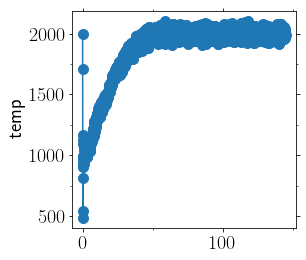

In [79]:
if not eval(confParser['flags']['RemoteMachine']):
    path = '../simulations/NiMultTemp/Temp2000K/Run0'

    #--- parse
    data = pd.read_csv('%s/thermo.txt'%path,delimiter=' ')

    #--- plot
    utl.PltErr(data.time,data.vol,ystr='vol')
    utl.PltErr(data.time,data.temp,ystr='temp')

    #--- mean 
    filtr = data.time > 100.0
    n = np.sum(filtr)
    mean_vol = data.vol[filtr].mean()
    err_vol = data.vol[filtr].std()/n**0.5

In [80]:
if not eval(confParser['flags']['RemoteMachine']):
    mean_vol = {}
    err_vol = {}
    temps = np.linspace(2000,3000,16)
    for temp in temps:
        path = '../simulations/NiMultTemp/Temp%sK/Run0'%int(temp)

        #--- parse
        data = pd.read_csv('%s/thermo.txt'%path,delimiter=' ')

        #--- plot
    #    utl.PltErr(data.time,data.vol,ystr='vol')
    #    utl.PltErr(data.time,data.temp,ystr='temp')

        #--- mean 
        filtr = data.time > 100.0
        n = np.sum(filtr)
        mean_vol[temp] = data.vol[filtr].mean()
        err_vol[temp] = data.vol[filtr].std()/n**0.5
    


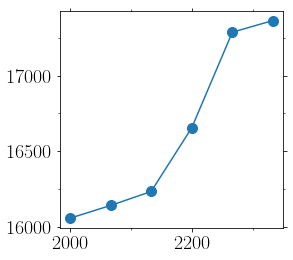

<AxesSubplot:>

In [85]:
if not eval(confParser['flags']['RemoteMachine']):
    filtr = temps>0
    utl.PltErr(temps[filtr],
               np.array(list(map(lambda x:mean_vol[x],temps)))[filtr],

              )

## jumps

mkdir: png: File exists


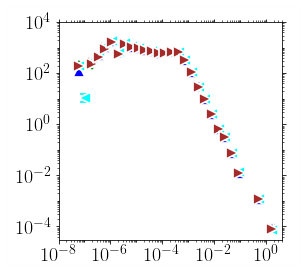

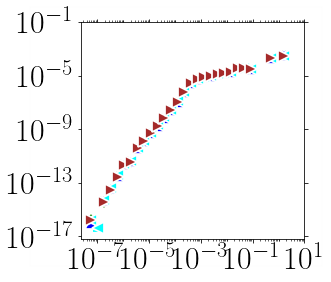

In [363]:
class JumpStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotPdf(self,scale=False,**kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun][0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            hist = data[:,1]
            bin_edges = data[:,0]
            err = data[:,2]
            
            #--- remove count == 1
            filtr = err == hist
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
            
            self.data_regr = np.c_[bin_edges,hist,err]
            if scale:
                hist *= bin_edges ** self.alpha
                err  *= bin_edges ** self.alpha
        #--- plot
#            temp= [1000,1200,1400,1600,1800,2000][indx]
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount+=self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                      legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def func(self,x,k,alpha):
        return k*x**alpha
    
    
    def fit(self,edge,hist,err):
        xdata=edge
        ydata=hist
        yerr=err
        popt, pcov = curve_fit(self.func,xdata,ydata,
                               p0=(1.0e-4,-2.0),
                               sigma=2*yerr,
                              )

        ax=utl.PltErr(edge,hist,yerr=2*err,fmt='.',
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,self.func(edge,*popt),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax,
#                   ylim=(1e-5,1000),
                  )
#        assert popt[-1]>0
        print('k,alpha',popt)
        return popt[0]
    
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = JumpStats(
        [1000,1200,1400,1600,1800,2000],
#        [1000,1200,1400,1600,1800,2000],
#        np.arange(1000,1440,80),
        1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-8,4e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                    'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                   'title':'png/jumpsPdf_nicocr.png'},

                       )
    
    #--- rescale
    stats.alpha = 2.5 #2.8 #3.0#2.5
    stats.PlotPdf(scale=True,
                **{'xscale':'log',
                  'yscale':'log',
                   'fontsize':32,
#                   'xlim':(1e-8,2e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':4,
                   'title':'png/jumpsPdf_rescaled_ni.png'},

                       )

### fit

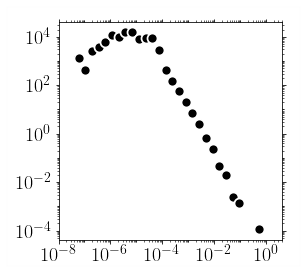

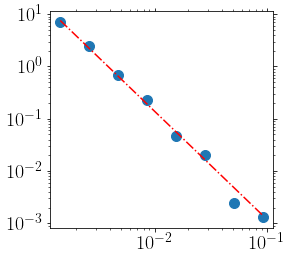

k,alpha [ 1.02005346e-05 -2.06802762e+00]


1.020053458672418e-05

In [317]:
if not eval(confParser['flags']['RemoteMachine']):

    stats = JumpStats(
        [2000],1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-8,4e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                    'bbox_to_anchor':(0.56,0.27,0.5,0.5),
#                    'title':'png/jumpsPdf_nicocr.png'
                          },

                       )
    filtr = np.all([stats.data_regr[:,0]>1e-3,stats.data_regr[:,0]<1e-1],axis=0)
    stats.fit(stats.data_regr[:,0][filtr],stats.data_regr[:,1][filtr],stats.data_regr[:,2][filtr])
    

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    Energy = lmpData.headers['Energy']
    data = self.data[kount:kount+self.nrun]
    if self.verbose:
        print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()

    filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays

    data = np.concatenate(np.array(data)[filtr]) #,axis=0)
    self.data_averaged[ temp ] = self.hist(data,log_scale)
    kount += self.nrun

## energy

### sampled energies

mkdir: png: File exists


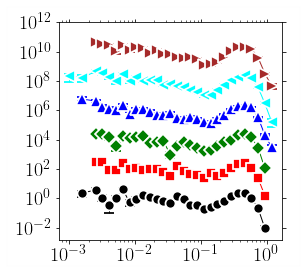

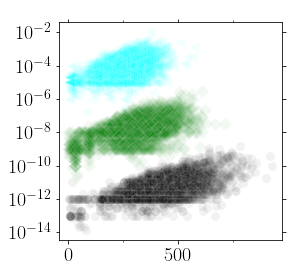

In [368]:
class EnergyStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def GetWaitTimes(self,times):
        times = times[0::2]
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
#        filtr = dtt > 0.0
        return dtt#[filtr]
    #
    def PlotPdf(self,shift=False,column_energy = 0,n_per_decade=8,
                **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        #
        kount = 0
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(kount,kount+self.nrun))))
            #--- remove zeros
            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
        
            #--- filtr
            filtr = hist == err
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
        #--- plot
            if shift:
                hist *= 100**indx if shift else 1
                err *= 100**indx if shift else 1

            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp), #,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount += self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
    def PlotPdfConcat(self,scale=False,
                      column_energy = 0,
                      type_column=0,
                      splitByType=True,
                      n_per_decade = 8,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
#            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(indx,indx+self.nrun))))
            data = np.concatenate(list(map(lambda x: self.data[x],range(kount,kount+self.nrun))))
#             types = np.concatenate(list(map(lambda x: self.data[x][:,type_column],range(indx,indx+self.nrun))))
            #--- remove zeros
#            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            data_concat = data.copy() if indx ==0 else np.concatenate([data_concat,data]) #np.c_[types,data] if indx ==0 else\
                        #np.concatenate([data_concat,np.c_[types,data]])
            kount += self.nrun
        if self.verbose:
            print('type.shape (concatenated):',data_concat.shape)
        
        #--- split by type
        if splitByType:
            df=pd.DataFrame(np.c_[data_concat[:,type_column],data_concat[:,column_energy]],
                            columns=['type','dE'])
            types=df.groupby(by='type').groups
            for itype in types:
                indices = types[itype]
                elist = np.array(df['dE'].iloc[indices])
                if self.verbose:
                    print('elist.shape:',elist.shape)

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(elist,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
                if scale:
                    hist *= 1000**int(itype)
                    err *= 1000**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=int(itype-1)%7,label=r'$%s$'%itype), #,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        else:
                data = data_concat[:,column_energy]
                data = data[data > 0.0]

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
#                 if scale:
#                     hist *= 100**int(itype)
#                     err *= 100**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=0), #,label=r'$%s$'%itype),#,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,

#                        legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def Scatter(self,shift=False,nevery=1,**kwargs):
        kb_inv=8.61732814974056e05
        
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=Symbols(markersizes=np.array([10,10,10,12,12,12,10])*8)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))

        #
        column_energy = 0
        column_time = 3
        kount = 0
        for indx in range(0,len(self.temps),nevery):
            temp = self.temps[indx]
            #--- concat. data for each temp            
            data_energy = np.concatenate(list(map(lambda x: self.GetEnergy(self.data[x][:,column_energy]),
                                                  range(kount,kount+self.nrun))))
            #--- wait_times
            data = self.data[indx:indx+self.nrun]
            data_waitTimes = np.concatenate(list(map(lambda x: self.GetWaitTimes(self.data[x][:,column_time]),
                                                     range(kount,kount+self.nrun))))

            if self.verbose:
                print('data_energy.shape (per temperature):',np.array(data_energy).shape)
                print('data_waitTimes.shape (per temperature):',np.array(data_waitTimes).shape)
            #--- plot scatter
            scale = 1e2 ** indx if shift else 1
            filtr = data_waitTimes > 0
#             utl.PltErr(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
#                         attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=1.0),
#                         ax = self.ax,
#                         Plot=False,
#                         )
            self.ax.scatter(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
                        **symbols.GetAttrsScatter(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=0.1/2),
                       )
            kount += self.nrun
            #--- plot average
#             nbins = 8
#             count, _=np.histogram(data_energy[filtr],bins=nbins)
#             xsum, _=np.histogram(data_energy[filtr],weights=data_energy[filtr],bins=nbins)
#             ysum, _=np.histogram(data_energy[filtr],weights=data_waitTimes[filtr],bins=nbins)
#             ysum /= count
# #            ysum =10 ** ysum 
#             xsum /= count
#             #---
#             utl.PltErr(xsum,ysum,
#                         attrs=symbols.GetAttrs(count=(indx)%7,label=r'$%s$'%temp,fmt='.'),
#                         ax = self.ax,
#                         Plot=False,
#                         )
        
        
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                     legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def GetEnergy(self,slist):
        n=len(slist)
        return slist[1:n:2]
            
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [1000,1400,1800,2000],8,
#        [1000, 1400,1800],8,
        #        np.arange(1000,1440,40),1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/timeseries.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=True,n_per_decade=10,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e0),
#                   'ylim':(1e-2,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_y':2,
                   'title':'png/BarrierPdf_cantor.png'},

                       )
    
#     stats.PlotPdfConcat(scale=False,
#                         splitByType = False,
#                         **{'xscale':'log',
#                       'yscale':'log',
#     #                   'xlim':(1e-3,1e0),
# #                        'ylim':(1e-2,1e2), #(1e-5,1e2),
#     #                           'xstr':r'$\Delta t$',
#     #                           'ystr':r'$P(\Delta t)$',
#     #                        'ndecade_x':2,'ndecade_y':2,
#     #                   'title':'png/BarrierPdf_cantor.png'
#                           },
#                        )

    stats.Scatter(nevery=2, shift = True,                        
                **{'xscale':'linear',
                  'yscale':'log',
#                   'xlim':(1e-3,1),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                     'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                        'ndecade_y':2,
                   'title':'png/twVsEnergy_nicocr.png',
                  }
)

mkdir: png: File exists


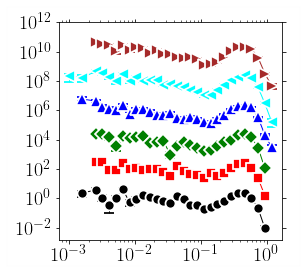

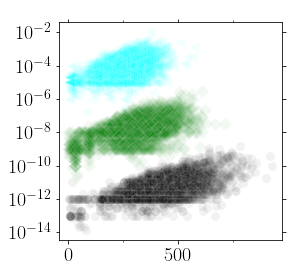

In [42]:
class EnergyStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def GetWaitTimes(self,times):
        times = times[0::2]
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
#        filtr = dtt > 0.0
        return dtt#[filtr]
    #
    def PlotPdf(self,shift=False,column_energy = 0,n_per_decade=8,
                **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        #
        kount = 0
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(kount,kount+self.nrun))))
            #--- remove zeros
            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
        
            #--- filtr
            filtr = hist == err
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
        #--- plot
            if shift:
                hist *= 100**indx if shift else 1
                err *= 100**indx if shift else 1

            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp), #,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount += self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
    def PlotPdfConcat(self,scale=False,
                      column_energy = 0,
                      type_column=0,
                      splitByType=True,
                      n_per_decade = 8,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
#            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(indx,indx+self.nrun))))
            data = np.concatenate(list(map(lambda x: self.data[x],range(kount,kount+self.nrun))))
#             types = np.concatenate(list(map(lambda x: self.data[x][:,type_column],range(indx,indx+self.nrun))))
            #--- remove zeros
#            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            data_concat = data.copy() if indx ==0 else np.concatenate([data_concat,data]) #np.c_[types,data] if indx ==0 else\
                        #np.concatenate([data_concat,np.c_[types,data]])
            kount += self.nrun
        if self.verbose:
            print('type.shape (concatenated):',data_concat.shape)
        
        #--- split by type
        if splitByType:
            df=pd.DataFrame(np.c_[data_concat[:,type_column],data_concat[:,column_energy]],
                            columns=['type','dE'])
            types=df.groupby(by='type').groups
            for itype in types:
                indices = types[itype]
                elist = np.array(df['dE'].iloc[indices])
                if self.verbose:
                    print('elist.shape:',elist.shape)

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(elist,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
                if scale:
                    hist *= 1000**int(itype)
                    err *= 1000**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=int(itype-1)%7,label=r'$%s$'%itype), #,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        else:
                data = data_concat[:,column_energy]
                data = data[data > 0.0]

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
#                 if scale:
#                     hist *= 100**int(itype)
#                     err *= 100**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=0), #,label=r'$%s$'%itype),#,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,

#                        legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def Scatter(self,shift=False,nevery=1,**kwargs):
        kb_inv=8.61732814974056e05
        
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=Symbols(markersizes=np.array([10,10,10,12,12,12,10])*8)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))

        #
        column_energy = 0
        column_time = 3
        kount = 0
        for indx in range(0,len(self.temps),nevery):
            temp = self.temps[indx]
            #--- concat. data for each temp            
            data_energy = np.concatenate(list(map(lambda x: self.GetEnergy(self.data[x][:,column_energy]),
                                                  range(kount,kount+self.nrun))))
            #--- wait_times
            data = self.data[indx:indx+self.nrun]
            data_waitTimes = np.concatenate(list(map(lambda x: self.GetWaitTimes(self.data[x][:,column_time]),
                                                     range(kount,kount+self.nrun))))

            if self.verbose:
                print('data_energy.shape (per temperature):',np.array(data_energy).shape)
                print('data_waitTimes.shape (per temperature):',np.array(data_waitTimes).shape)
            #--- plot scatter
            scale = 1e2 ** indx if shift else 1
            filtr = data_waitTimes > 0
#             utl.PltErr(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
#                         attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=1.0),
#                         ax = self.ax,
#                         Plot=False,
#                         )
            self.ax.scatter(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
                        **symbols.GetAttrsScatter(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=0.1/2),
                       )
            kount += self.nrun
            #--- plot average
#             nbins = 8
#             count, _=np.histogram(data_energy[filtr],bins=nbins)
#             xsum, _=np.histogram(data_energy[filtr],weights=data_energy[filtr],bins=nbins)
#             ysum, _=np.histogram(data_energy[filtr],weights=data_waitTimes[filtr],bins=nbins)
#             ysum /= count
# #            ysum =10 ** ysum 
#             xsum /= count
#             #---
#             utl.PltErr(xsum,ysum,
#                         attrs=symbols.GetAttrs(count=(indx)%7,label=r'$%s$'%temp,fmt='.'),
#                         ax = self.ax,
#                         Plot=False,
#                         )
        
        
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                     legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def GetEnergy(self,slist):
        n=len(slist)
        return slist[1:n:2]
            
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [1000,1400,1800,2000],8,
#        [1000, 1400,1800],8,
        #        np.arange(1000,1440,40),1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/timeseries.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=True,n_per_decade=10,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e0),
#                   'ylim':(1e-2,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_y':2,
                   'title':'png/BarrierPdf_cantor.png'},

                       )
    
#     stats.PlotPdfConcat(scale=False,
#                         splitByType = False,
#                         **{'xscale':'log',
#                       'yscale':'log',
#     #                   'xlim':(1e-3,1e0),
# #                        'ylim':(1e-2,1e2), #(1e-5,1e2),
#     #                           'xstr':r'$\Delta t$',
#     #                           'ystr':r'$P(\Delta t)$',
#     #                        'ndecade_x':2,'ndecade_y':2,
#     #                   'title':'png/BarrierPdf_cantor.png'
#                           },
#                        )

    stats.Scatter(nevery=2, shift = True,                        
                **{'xscale':'linear',
                  'yscale':'log',
#                   'xlim':(1e-3,1),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                     'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                        'ndecade_y':2,
                   'title':'png/twVsEnergy_nicocr.png',
                  }
)

### Events dir

mkdir: png: File exists


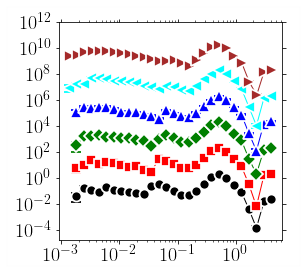

In [43]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [2000],8,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=True,column_energy=3,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e-1),
#                    'ylim':(1e-2,1e0), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':1,'ndecade_y':2,
                    'bbox_to_anchor':(0.4,0.13,0.5,0.5),
                   'title':'png/BarrierPdf_nicocr.png'},

                       )

#     stats.PlotPdfConcat(scale=True, 
#                         column_energy=3,
#                         splitByType = False,
#                         n_per_decade=10,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1e-1),
# #                   'ylim':(1e-2,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
# #                        'ndecade_x':2,'ndecade_y':2,
# #                   'title':'png/BarrierPdf_cantor.png'
#                           },

#                        )



mkdir: png: File exists
0.8550750193563137


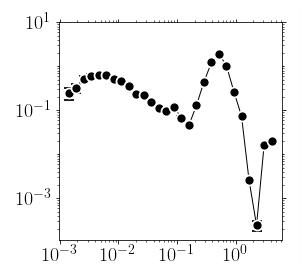

In [64]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [2000],8,
#        [2000],8,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    print(stats.data[0][:,3].mean())
    stats.PlotPdf(shift=True,column_energy=3,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e-1),
#                    'ylim':(1e-2,1e0), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':1,'ndecade_y':2,
                    'bbox_to_anchor':(0.4,0.13,0.5,0.5),
                   'title':'png/BarrierPdf_nicocr.png'},

                       )

#     stats.PlotPdfConcat(scale=True, 
#                         column_energy=3,
#                         splitByType = False,
#                         n_per_decade=10,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1e-1),
# #                   'ylim':(1e-2,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
# #                        'ndecade_x':2,'ndecade_y':2,
# #                   'title':'png/BarrierPdf_cantor.png'
#                           },

#                        )



(6.329740912454023, 5.525964288650337)

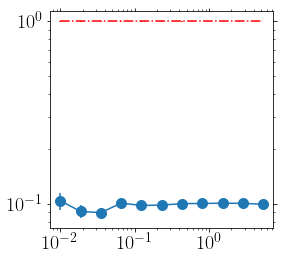

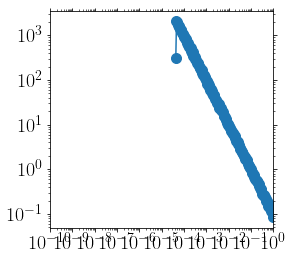

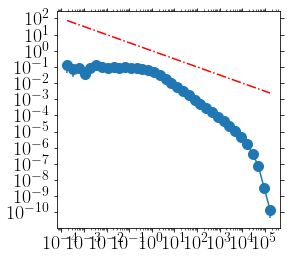

NameError: name 'fit' is not defined

In [48]:
if not eval(confParser['flags']['RemoteMachine']):
    kb=8.61732814974056e-05

    0.9/1650/kb,1.0/2100/kb
    #alpha=-0.4

    Emin=1e-2
    Emax=1e1
    n=100000
    for alpha in [-1]:
        xmax=1/Emin**alpha
        xmin=1/Emax**alpha
        x=np.random.uniform(low=xmin,high=xmax,size=n)
        #E=np.exp(-E)
        E=x**-(1/alpha)
        hist, edge,err = utl.GetPDF(E,n_per_decade=4)
        ax=utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',Plot=False,
                  )

        utl.PltErr(edge,1/edge**(1+alpha),yerr=err,attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax
                  )

        #
        lambdaa=np.exp(-E)
        lambdaa = lambdaa[lambdaa>0]
        hist, edge,err = utl.GetPDF(lambdaa,n_per_decade=32)
        utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',
                   xlim=(1e-10,1),
                  )

        sarr = np.c_[list(map(lambda x:np.random.exponential(1/x,size=1),lambdaa))].flatten()
        hist, edge,err = utl.GetPDF(sarr,n_per_decade=4)
        ax=utl.PltErr(edge,hist*edge**0,yerr=err*edge**0,
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,1/edge**(1.5+alpha),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax
                  )
        beta=fit(edge,hist,err)
        print(beta)
        plt.scatter(alpha,beta)
    plt.show()

In [ ]:
def func(x,beta,k,x0,x1):
#    return k/(1+(x/x0)**beta)
    return k*np.exp(-x/x1)/(1+(x/x0)**beta)
    
def fit(edge,hist,err):
    xdata=edge
    ydata=hist
    yerr=err
    popt, pcov = curve_fit(func,xdata,ydata,
                          p0=(2,1,10,1e3),
                           sigma=yerr,
                          )

    ax=utl.PltErr(edge,hist,yerr=err,
               yscale='log',xscale='log',
                  Plot=False
              )
    utl.PltErr(edge,func(edge,*popt),attrs={'fmt':'-.r'},
               yscale='log',xscale='log',
               ax=ax,
               ndecade_x=4,
              )
    assert popt[-1]>0
    return popt[0]

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    kbt=1000*8.61732814974056e-05
    E=5e-2
    print('%e'%(1.0/(1e-13*np.exp(E/kbt))))

### catalogs

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
#        [1000,1200,1400,1600,1800,2000],8,
        [2000],8
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier_catalog_type5.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier_catalog_type3.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )

    stats.PlotPdf( 
                        column_energy=2,
                        splitByType = False,
                        n_per_decade = 8,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e0),
#                   'ylim':(1e-3,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                        'ndecade_x':2,'ndecade_y':2,
#                   'title':'png/BarrierPdf_cantor.png'
                          },

                       )

    

#     stats.Scatter(nevery=2,                        
#                 **{'xscale':'linear',
#                   'yscale':'log',
#                    'xlim':(0,1),
# #                   'ylim':(1e-3,1e1), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                         'ndecade_y':2,
#                    'title':'png/twVsEnergy_cantor.png',
#                   }
# )